In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 6.2 MB/s eta 0:00:00


In [ ]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
#from tslearn.clustering import silhouette_score as ts_silhouette
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### K-Means Clustering Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


I am using the large dataset from https://doi.org/10.5281/zenodo.3701260. Dataset contains forty-three variables: for each of the PID
controllers, setpoint, process value and output (SV/PV/MV)
were recorded. All variables will be loaded into a pd dataframe

In [ ]:
df_vars = pd.read_excel("data_by_description.xlsx", skiprows = [1,2], usecols = "B : AR", convert_float=False) #converters={'OSA3S16SO.PV':float, 'OSA4S20SO.PV':float}) #dtype = {'OSA3S16SO.PV':np.float64, 'OSA4S20SO.PV':np.float64})
df_vars.head()

<ipython-input-5-fb5c5131056b>:1: FutureWarning: convert_float is deprecated and will be removed in a future version.
  df_vars = pd.read_excel("data_by_description.xlsx", skiprows = [1,2], usecols = "B : AR", convert_float=False) #converters={'OSA3S16SO.PV':float, 'OSA4S20SO.PV':float}) #dtype = {'OSA3S16SO.PV':np.float64, 'OSA4S20SO.PV':np.float64})


FI60320.PV  FIC60324.MV  FIC60324.PV  FIC60324.SV  FIC60327.MV  \
0  476.614716    47.088615   249.305069        250.0    49.441315   
1  480.224030    47.102135   249.800568        250.0    49.400452   
2  481.814880    47.115654   250.387115        250.0    49.359592   
3  477.350372    47.129173   250.973663        250.0    49.110222   
4  472.885864    47.142693   251.560211        250.0    48.814049   

   FIC60327.PV  FIC60327.SV  FIC60331.MV  FIC60331.PV  FIC60331.SV  ...  \
0   299.838257        300.0    61.200512   502.976379        500.0  ...   
1   300.065247        300.0    61.243736   500.191132        500.0  ...   
2   300.428558        300.0    61.286961   497.405884        500.0  ...   
3   300.791901        300.0    61.330185   494.620636        500.0  ...   
4   301.155243        300.0    61.373409   493.097168        500.0  ...   

   OSA3S16SO.PV  OSA3S16ZN.PV  OSA3S17FE.PV  OSA3S17PB.PV  OSA3S17SO.PV  \
0       18.4841       11.1213       6.95405       2.25000         41.75   
1       18.4841       11.1213       6.90372       2.45313         41.75   
2     16.635799       11.1213       6.90372       2.45313         41.75   
3     16.635799       11.1213       6.90372       2.45313         41.75   
4     16.635799       11.1213       6.90372       2.45313         41.75   

   OSA3S17ZN.PV  OSA4S20FE.PV  OSA4S20PB.PV  OSA4S20SO.PV  OSA4S20ZN.PV  
0        42.778         11.88       1.22656         28.25       4.01969  
1        42.778         11.88       1.22656         28.25       4.01969  
2        42.778         11.88       1.22656         28.25       4.01969  
3        42.778         11.88       1.22656         28.25       4.01969  
4        42.778         11.88       1.22656         28.25       4.01969  

[5 rows x 43 columns]

Checking the overall info of dataframe to make sure every variables have the same length and type of float

In [ ]:
df_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44641 entries, 0 to 44640
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FI60320.PV    44641 non-null  float64
 1   FIC60324.MV   44641 non-null  float64
 2   FIC60324.PV   44641 non-null  float64
 3   FIC60324.SV   44641 non-null  float64
 4   FIC60327.MV   44641 non-null  float64
 5   FIC60327.PV   44641 non-null  float64
 6   FIC60327.SV   44641 non-null  float64
 7   FIC60331.MV   44641 non-null  float64
 8   FIC60331.PV   44641 non-null  float64
 9   FIC60331.SV   44641 non-null  float64
 10  FIC60334.MV   44641 non-null  float64
 11  FIC60334.PV   44641 non-null  float64
 12  FIC60334.SV   44641 non-null  float64
 13  FIC60620.MV   44641 non-null  float64
 14  FIC60620.PV   44641 non-null  float64
 15  FIC60620.SV   44641 non-null  float64
 16  FIC60624.MV   44641 non-null  float64
 17  FIC60624.PV   44641 non-null  float64
 18  FIC60624.SV   44641 non-nu

I don't really know why, but two variables: 

"OSA4S20SO.PV", [41]
"OSA3S16SO.PV", [33]

have type "object" after uploading. For now we are not using those variables anyway, so I chose to ignore that fact

Checking if there is some missing data

In [ ]:
#Checking empty values
df_vars.isna().sum().sum()

0

Loading Description and UOM of variables into a separate dataframe to use for annotations on plots later

In [ ]:
df_descriptions = pd.read_excel("data_by_description.xlsx", nrows = 2, index_col = 0, usecols = "A : AR", convert_float=False) #converters={'OSA3S16SO.PV':float, 'OSA4S20SO.PV':float}) #dtype = {'OSA3S16SO.PV':np.float64, 'OSA4S20SO.PV':np.float64})
df_descriptions.head()

<ipython-input-6-db00460ab9fd>:1: FutureWarning: convert_float is deprecated and will be removed in a future version.
  df_descriptions = pd.read_excel("data_by_description.xlsx", nrows = 2, index_col = 0, usecols = "A : AR", convert_float=False) #converters={'OSA3S16SO.PV':float, 'OSA4S20SO.PV':float}) #dtype = {'OSA3S16SO.PV':np.float64, 'OSA4S20SO.PV':np.float64})


FI60320.PV       FIC60324.MV       FIC60324.PV       FIC60324.SV  \
Description  Feed rate  Air flow to FC23  Air flow to FC23  Air flow to FC23   
UOM                l/s             m3/hr             m3/hr             m3/hr   

                  FIC60327.MV       FIC60327.PV       FIC60327.SV  \
Description  Air flow to FC24  Air flow to FC24  Air flow to FC24   
UOM                     m3/hr             m3/hr             m3/hr   

                  FIC60331.MV       FIC60331.PV       FIC60331.SV  ...  \
Description  Air flow to FC25  Air flow to FC25  Air flow to FC25  ...   
UOM                     m3/hr             m3/hr             m3/hr  ...   

                    OSA3S16SO.PV OSA3S16ZN.PV            OSA3S17FE.PV  \
Description  Feed percent solids      Feed Zn  Primary Rougher Con FE   
UOM                            %            %                       %   

                       OSA3S17PB.PV            OSA3S17SO.PV  \
Description  Primary Rougher Con PB  Primary Rougher Con SO   
UOM                               %                       %   

                       OSA3S17ZN.PV             OSA4S20FE.PV  \
Description  Primary Rougher Con Zn  Primary Rougher Tail FE   
UOM                               %                        %   

                        OSA4S20PB.PV             OSA4S20SO.PV  \
Description  Primary Rougher Tail PB  Primary Rougher Tail SO   
UOM                                %                        %   

                        OSA4S20ZN.PV  
Description  Primary Rougher Tail Zn  
UOM                                %  

[2 rows x 43 columns]

For partitioning the dataset, only process output variables will be used


In [ ]:
#Dropping all variables exept "Process values"
df_pvs = df_vars.filter(regex='.PV$', axis=1)
df_descriptions = df_descriptions.filter(regex='.PV$', axis=1)

In [ ]:
#Leaving only the input variables
df_input_pvs = df_pvs.drop(df_pvs.filter(regex='OSA').columns, axis=1)
df_descriptions = df_descriptions.drop(df_descriptions.filter(regex='OSA').columns, axis=1)

In [ ]:
# df_input_pvs.drop("FI60320.PV", axis = 1, inplace = True)
# df_descriptions.drop("FI60320.PV", axis = 1, inplace = True)

In [ ]:
df_descriptions.head(n=1).T

Description
FI60320.PV             Feed rate
FIC60324.PV     Air flow to FC23
FIC60327.PV     Air flow to FC24
FIC60331.PV     Air flow to FC25
FIC60334.PV     Air flow to FC26
FIC60620.PV  CuSO4 to FC22 tails
FIC60624.PV           EX to FC23
FIC60625.PV           EX to FC25
FIC6492.PV      NS to FC3 tails 
LIC60330.PV           FC24 Level
LIC60337.PV           FC26 Level

In [ ]:
df_input_pvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44641 entries, 0 to 44640
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FI60320.PV   44641 non-null  float64
 1   FIC60324.PV  44641 non-null  float64
 2   FIC60327.PV  44641 non-null  float64
 3   FIC60331.PV  44641 non-null  float64
 4   FIC60334.PV  44641 non-null  float64
 5   FIC60620.PV  44641 non-null  float64
 6   FIC60624.PV  44641 non-null  float64
 7   FIC60625.PV  44641 non-null  float64
 8   FIC6492.PV   44641 non-null  float64
 9   LIC60330.PV  44641 non-null  float64
 10  LIC60337.PV  44641 non-null  float64
dtypes: float64(11)
memory usage: 3.7 MB


Normalizing the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
norm = scaler.fit_transform(df_input_pvs)
norm_df_input_pvs = pd.DataFrame(norm,columns=[df_input_pvs.columns])

Building correlation plot to see what variables are related to each other

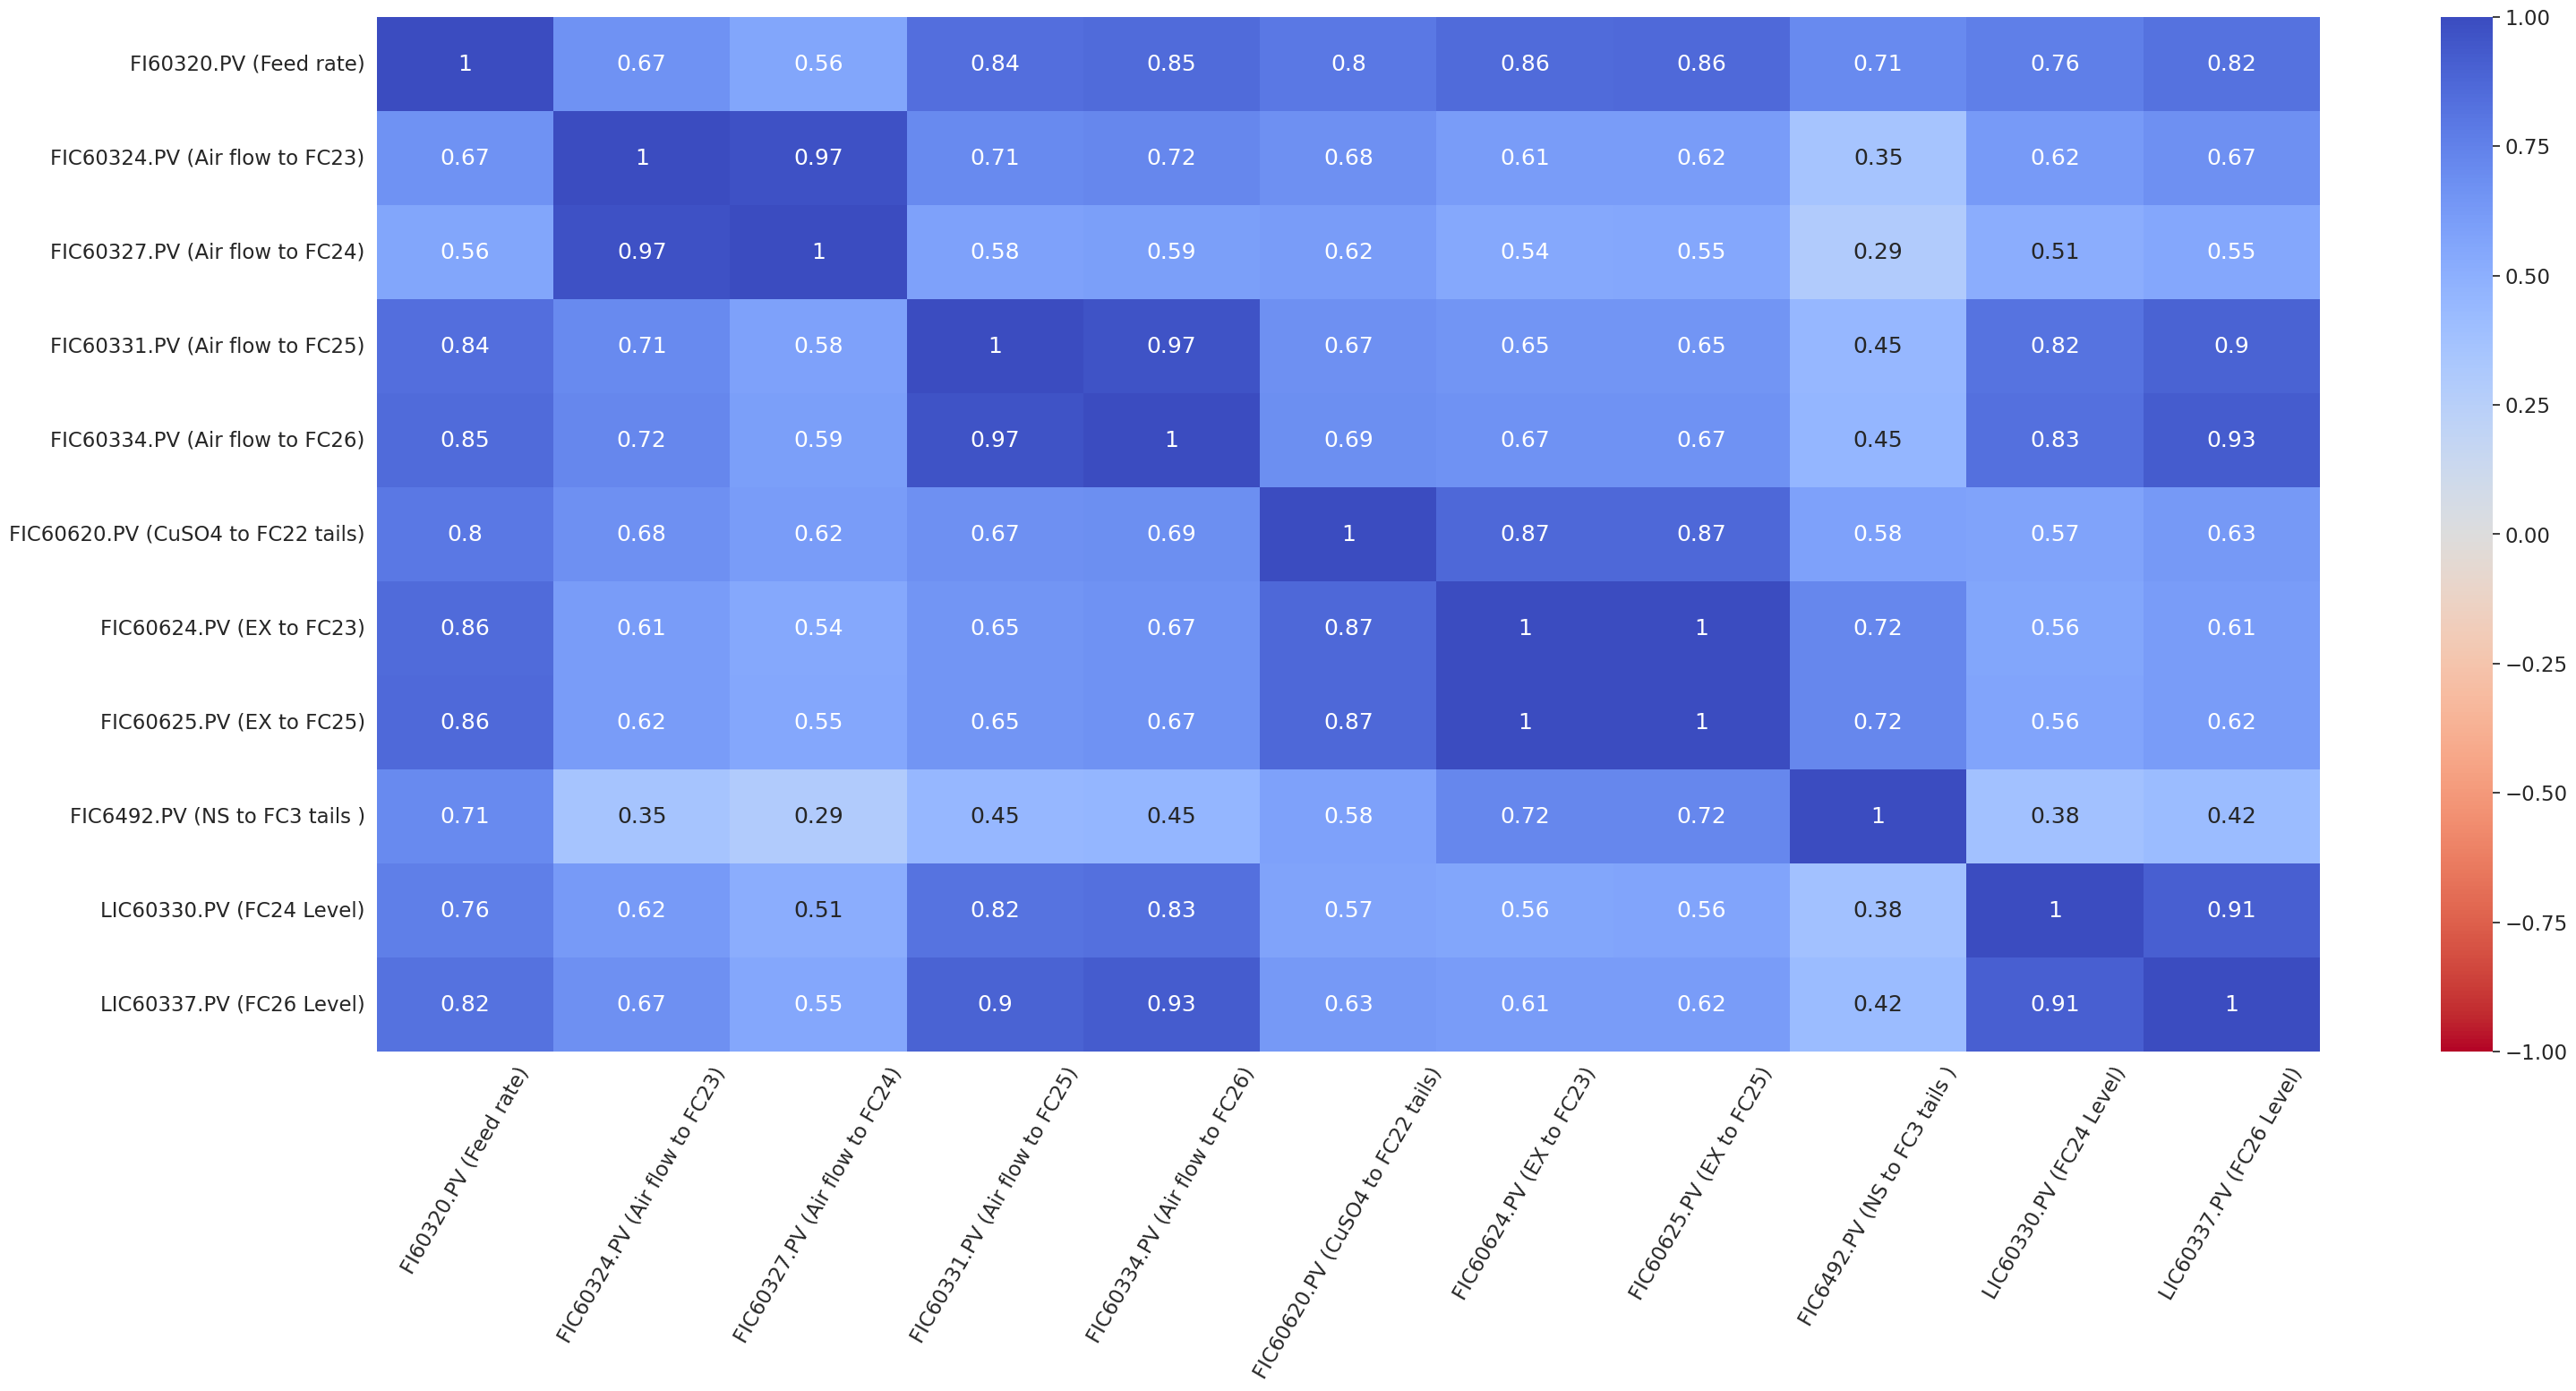

In [ ]:
corrM = df_input_pvs.corr()

plt.figure(figsize=(35, 15))
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corrM, vmin=-1, vmax=1, annot=True, cmap="coolwarm_r")#, xticklabels = df_descriptions.loc['Description'][:], yticklabels = df_descriptions.loc['Description'][:])
texts = [t.get_text() for t in heatmap.get_xticklabels()]
texts = [texts[t] +  ' (' + df_descriptions.loc['Description'][t] + ')' for t in range(len(texts))]
heatmap.set_yticklabels(texts, rotation = 0);
heatmap.set_xticklabels(texts,rotation=60);#

In [ ]:
norm_df_input_pvs.corr()

FI60320.PV FIC60324.PV FIC60327.PV FIC60331.PV FIC60334.PV  \
FI60320.PV    1.000000    0.666198    0.557698    0.836561    0.852621   
FIC60324.PV   0.666198    1.000000    0.973573    0.710785    0.723730   
FIC60327.PV   0.557698    0.973573    1.000000    0.580044    0.594074   
FIC60331.PV   0.836561    0.710785    0.580044    1.000000    0.968011   
FIC60334.PV   0.852621    0.723730    0.594074    0.968011    1.000000   
FIC60620.PV   0.795914    0.677888    0.616959    0.673102    0.687179   
FIC60624.PV   0.856868    0.612841    0.543463    0.650409    0.666570   
FIC60625.PV   0.860748    0.616489    0.547220    0.653244    0.669503   
FIC6492.PV    0.710418    0.352629    0.294659    0.446559    0.454019   
LIC60330.PV   0.760567    0.623597    0.508601    0.819271    0.831774   
LIC60337.PV   0.820577    0.674649    0.549579    0.896743    0.926112   

            FIC60620.PV FIC60624.PV FIC60625.PV FIC6492.PV LIC60330.PV  \
FI60320.PV     0.795914    0.856868    0.860748   0.710418    0.760567   
FIC60324.PV    0.677888    0.612841    0.616489   0.352629    0.623597   
FIC60327.PV    0.616959    0.543463    0.547220   0.294659    0.508601   
FIC60331.PV    0.673102    0.650409    0.653244   0.446559    0.819271   
FIC60334.PV    0.687179    0.666570    0.669503   0.454019    0.831774   
FIC60620.PV    1.000000    0.873823    0.870702   0.582012    0.573656   
FIC60624.PV    0.873823    1.000000    0.996285   0.720660    0.560448   
FIC60625.PV    0.870702    0.996285    1.000000   0.721337    0.563028   
FIC6492.PV     0.582012    0.720660    0.721337   1.000000    0.380167   
LIC60330.PV    0.573656    0.560448    0.563028   0.380167    1.000000   
LIC60337.PV    0.632674    0.613024    0.615527   0.418257    0.910207   

            LIC60337.PV  
FI60320.PV     0.820577  
FIC60324.PV    0.674649  
FIC60327.PV    0.549579  
FIC60331.PV    0.896743  
FIC60334.PV    0.926112  
FIC60620.PV    0.632674  
FIC60624.PV    0.613024  
FIC60625.PV    0.615527  
FIC6492.PV     0.418257  
LIC60330.PV    0.910207  
LIC60337.PV    1.000000

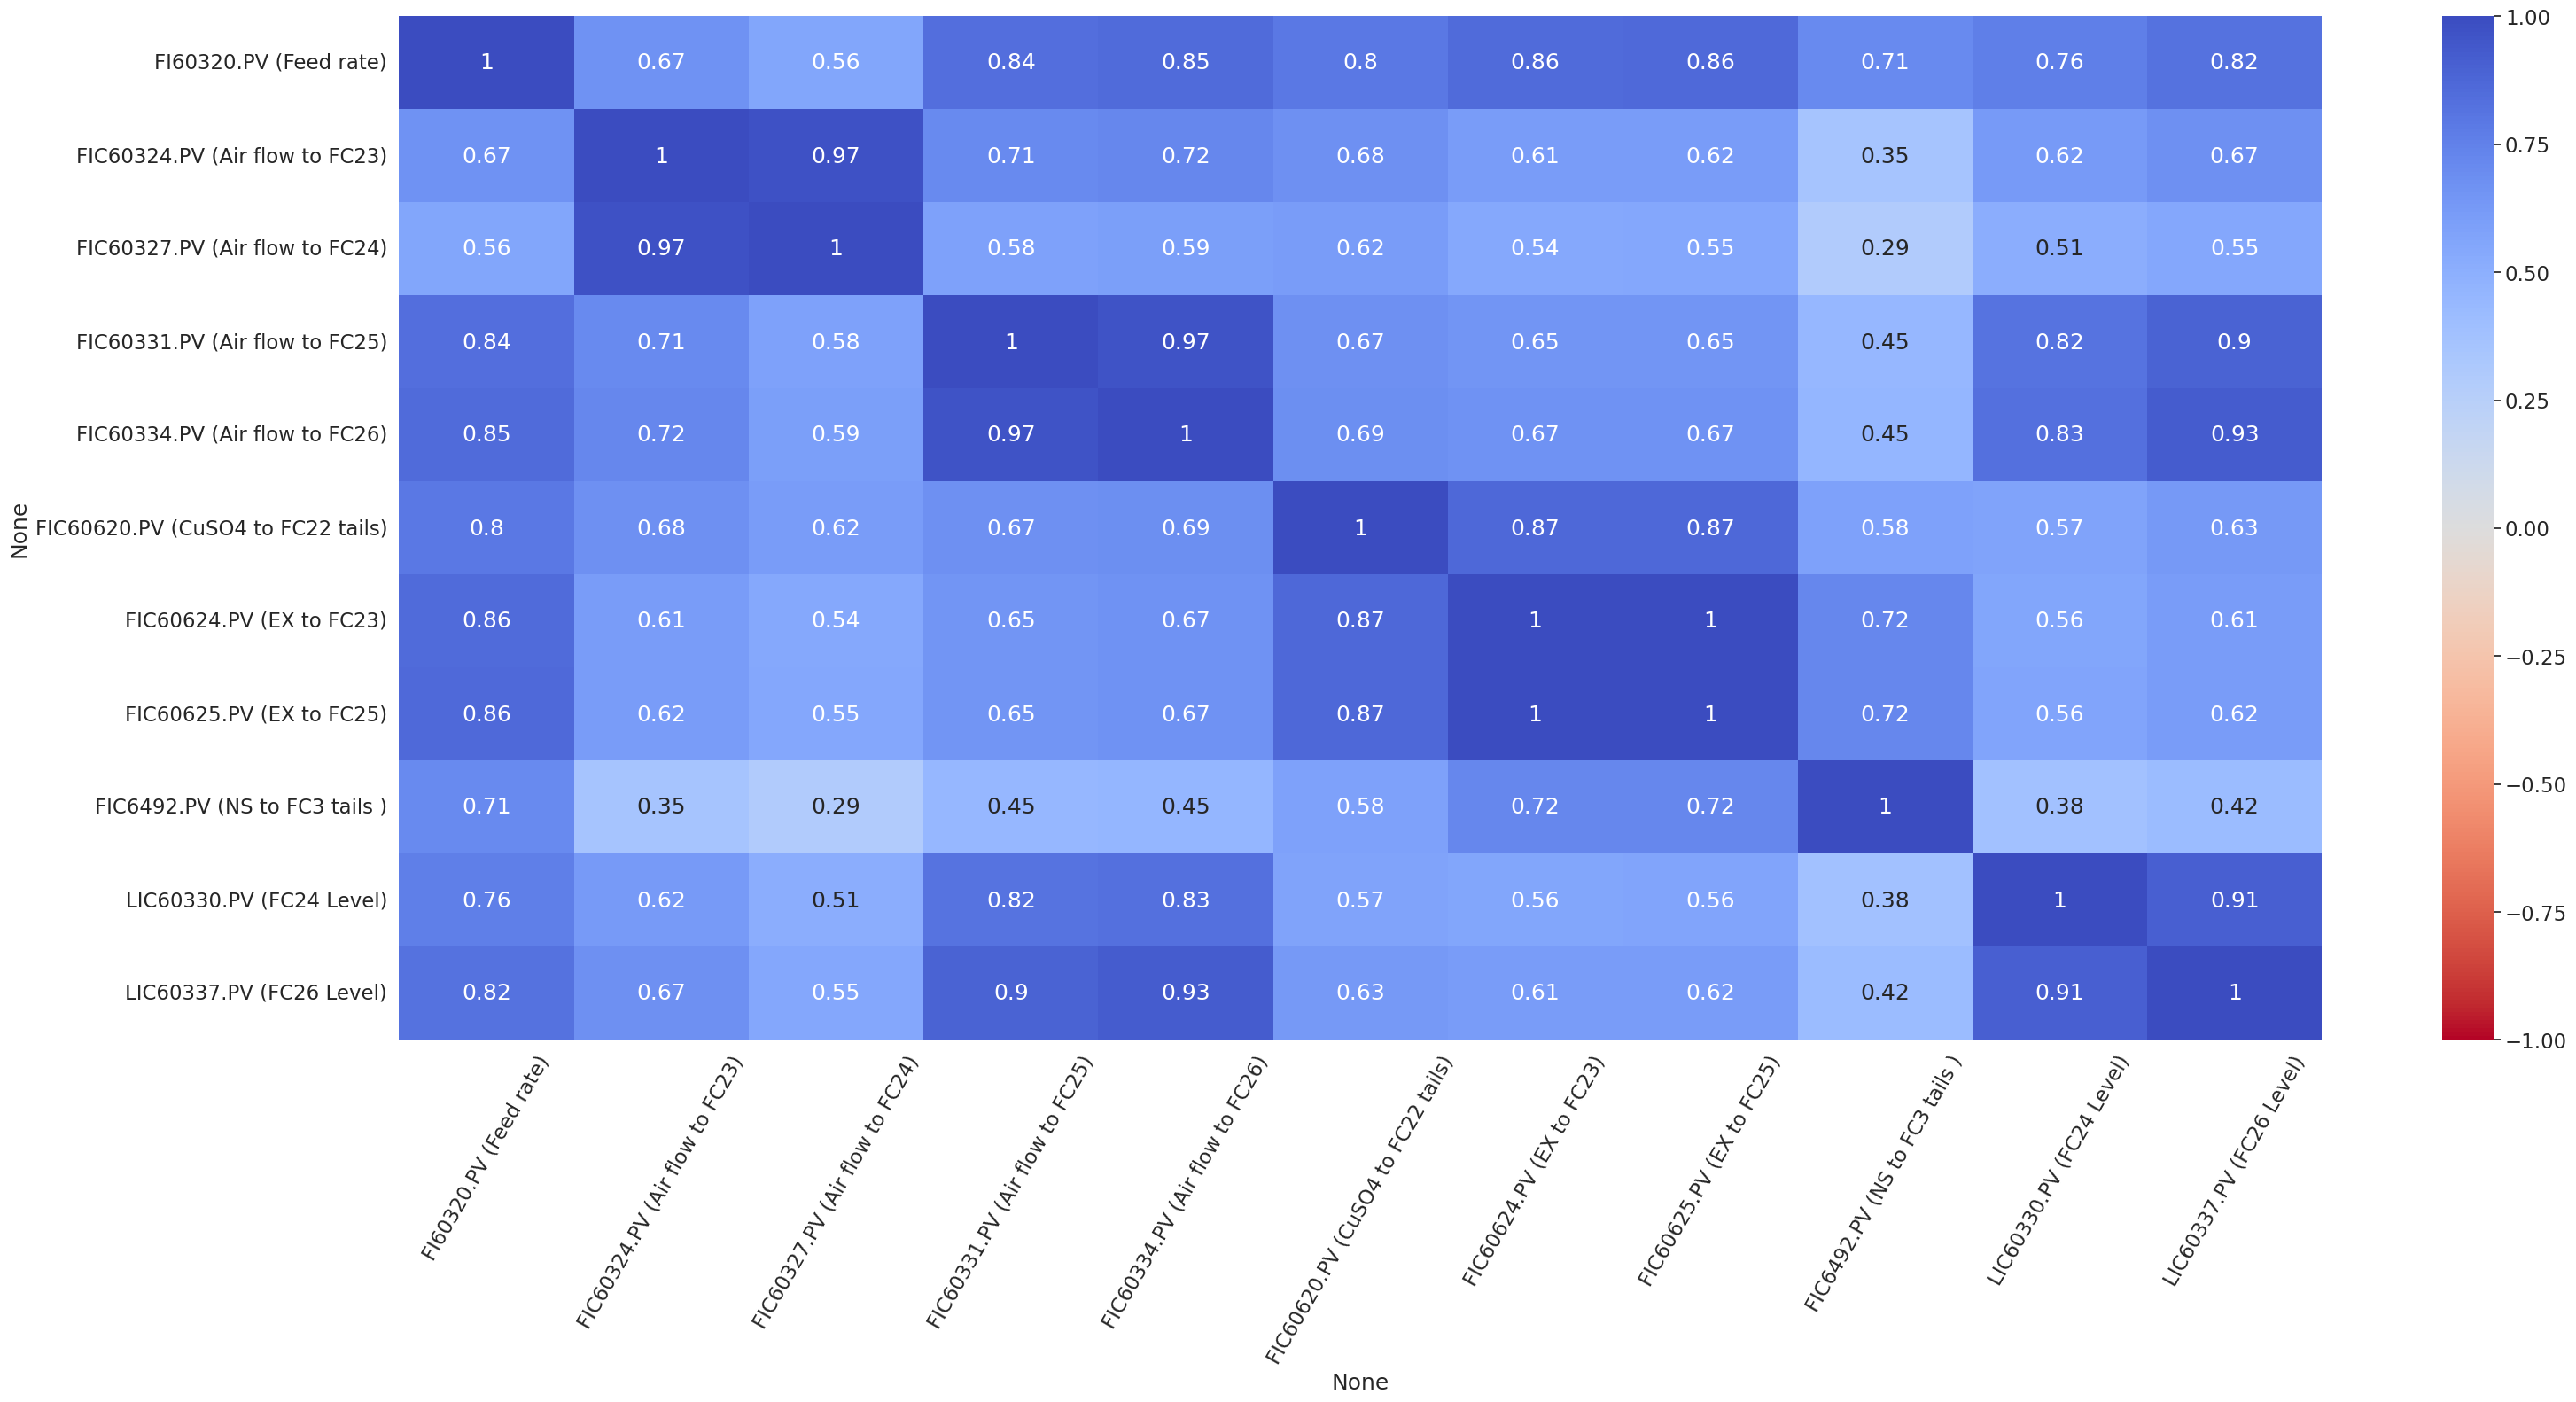

In [ ]:
corrM1 = norm_df_input_pvs.corr()

plt.figure(figsize=(35, 15))
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corrM1, vmin=-1, vmax=1, annot=True, cmap="coolwarm_r")#, xticklabels = df_descriptions.loc['Description'][:], yticklabels = df_descriptions.loc['Description'][:])
texts = [t.get_text() for t in heatmap.get_xticklabels()]
texts = [texts[t] +  ' (' + df_descriptions.loc['Description'][t] + ')' for t in range(len(texts))]
heatmap.set_yticklabels(texts, rotation = 0);
heatmap.set_xticklabels(texts,rotation=60);#

Creating an array for clustering and plotting the data for a chosen time period

In [ ]:
#Loading date and time data into a separate dataframe
datetime = pd.read_excel("data_by_description.xlsx", skiprows = [1,2], usecols=[0], names = ["Date/time"])
x = datetime[:10080]

Time period of one week was chosen, since longer periods require more RAM than the free version of Google Collab

In [ ]:
data_array = np.array(norm_df_input_pvs.iloc[:10080].T.values)

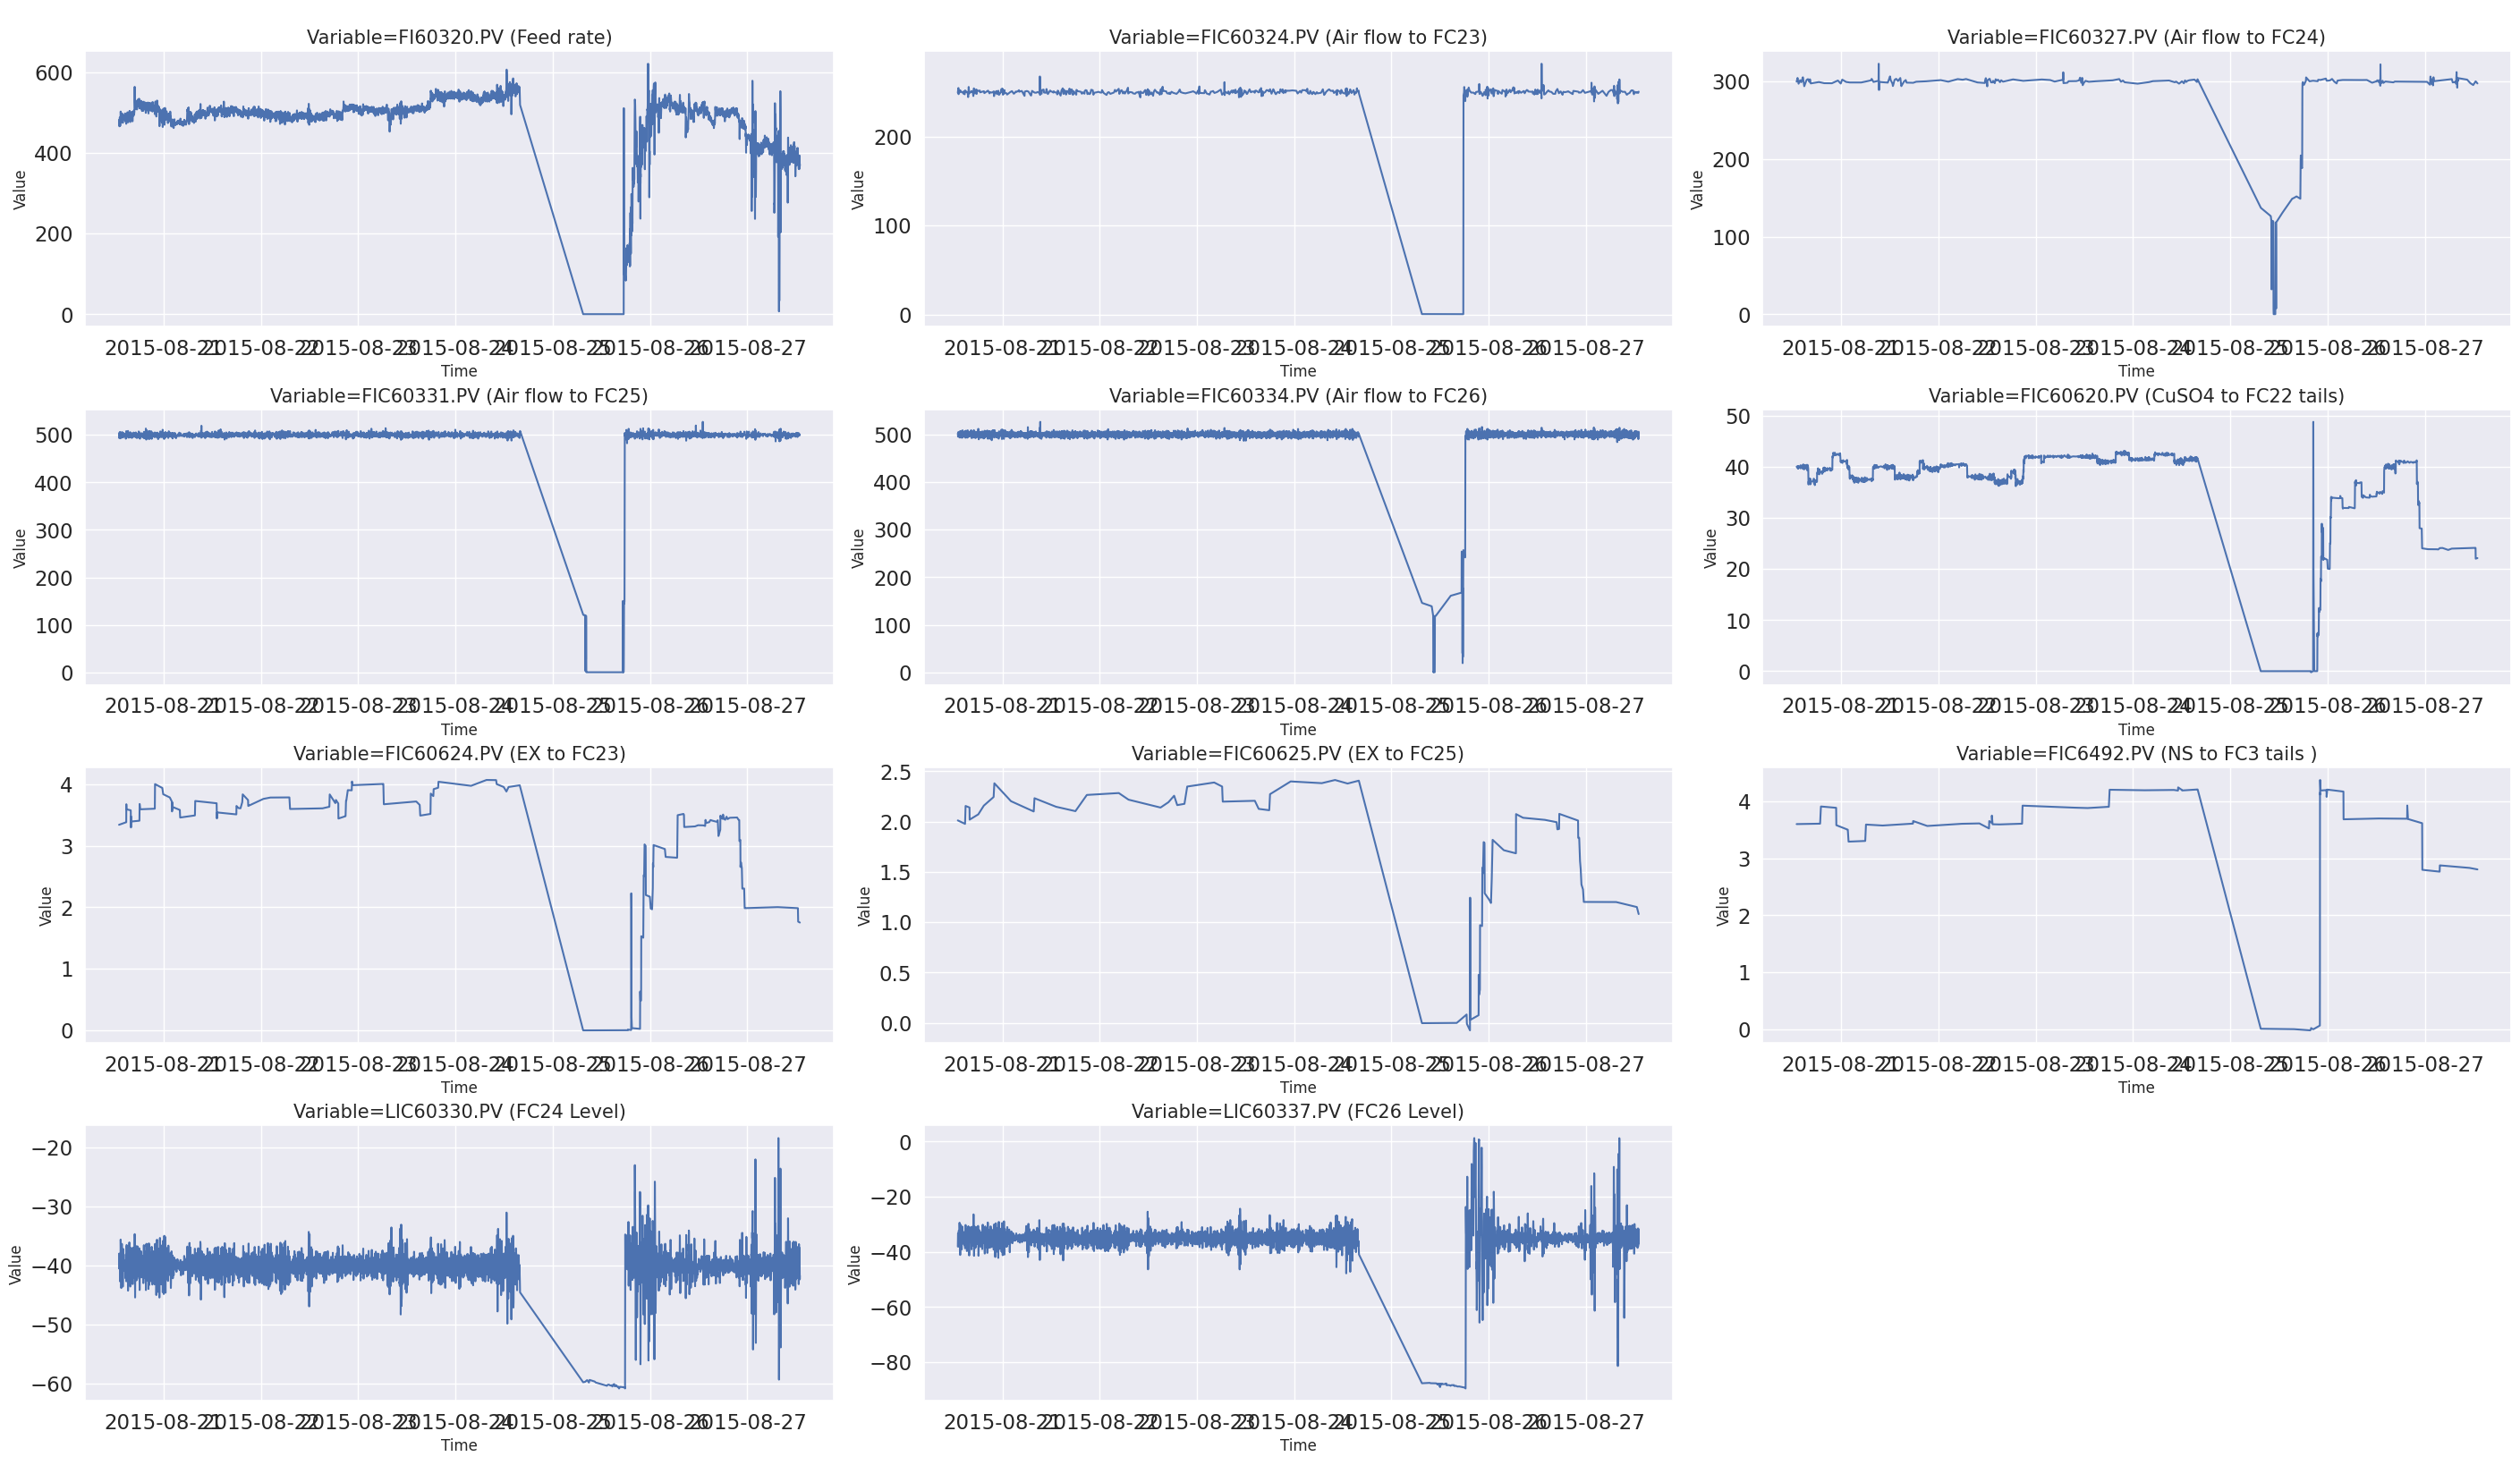

In [ ]:
plt.figure(figsize=(35,30))
#plt.tight_layout()
for j in range(1,12):
  plt.subplot(6,3,j)
  plt.plot(datetime.iloc[:10080],df_input_pvs.iloc[:10080, (j-1)])
  plt.ylabel('Value',fontsize=12)
  plt.xlabel('Time\n',fontsize=12)
  plt.title('\nVariable=%s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')'),fontsize=15)
  #plt.ylim(data_array.min(),data_array.max()

plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show();

### Identifying possible number of clusters


A way to identify best number of clusters using the Inertia criterion, that shows the overall spreading of clusters, is an Elbow Method. Calculating value of Inertia for different number of clusters, plotting it and examining visually, the inflection point where there change of inertia value goes from rapid to modest, can be identified.

Another way is to check different metric: silhouette coefficient, that shows overall similarity between 

In [ ]:
# A dictionary used for test clustering
kmeans_kwargs = {
    "init": "k-means++",
    "max_iter": 10,
    "n_init": 5,
    "random_state": 42,
}

In [ ]:
# Creating to lists that hold SSE and silhouette values for each k
sse = []
silhouette_answ = []
for k in range(2, 11):
    kmeans_pp = KMeans(n_clusters=k, **kmeans_kwargs)
    labels = kmeans_pp.fit_predict(data_array)
    sse.append(kmeans_pp.inertia_)
    silhouette_answ.append(silhouette_score(data_array, labels, metric='euclidean'))

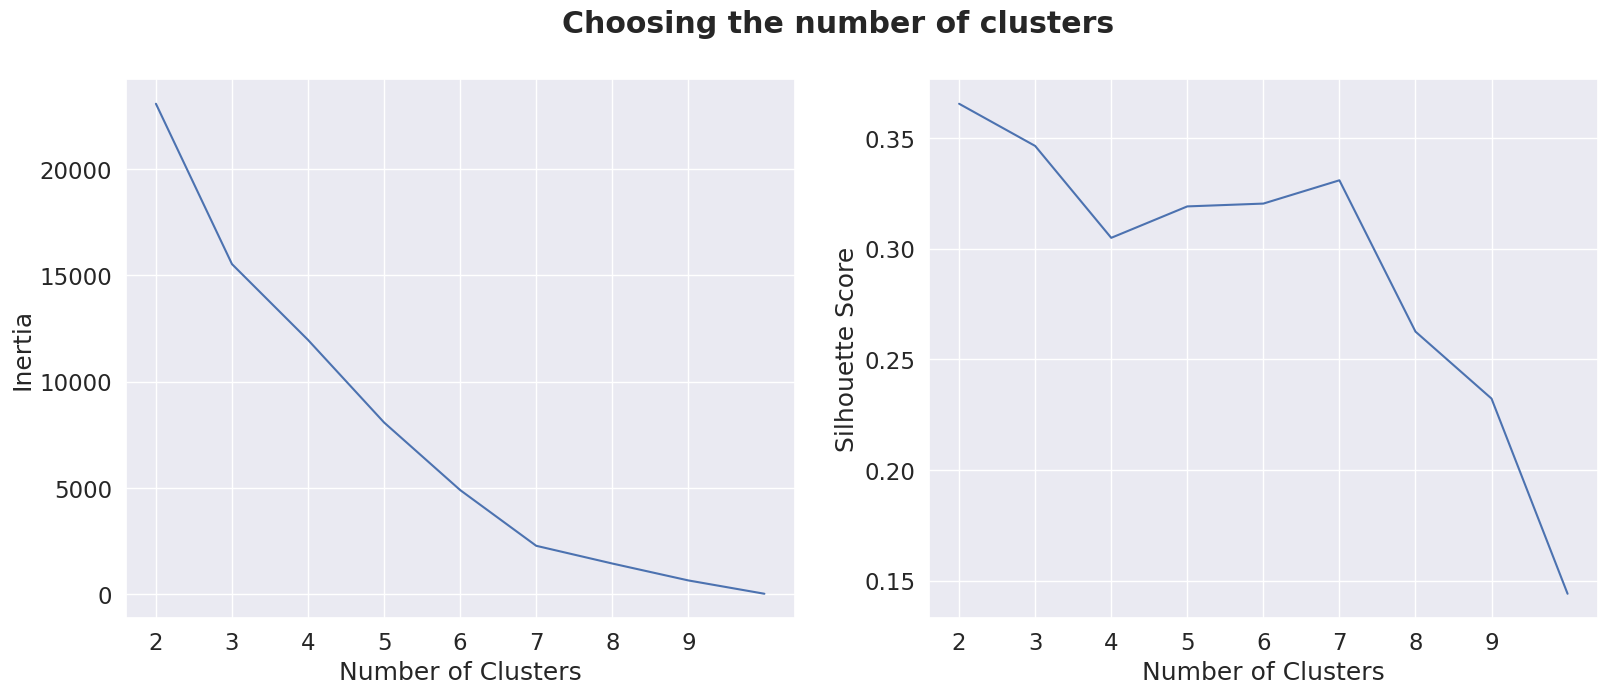

In [ ]:
# Plotting inertia and silhouette 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(19)

ax1.plot(range(2, 11), sse)
ax1.set_xticks(range(2, 10))
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inertia")

ax2.plot(range(2, 11), silhouette_answ)
ax2.set_xticks(range(2, 10))
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")

plt.suptitle("Choosing the number of clusters", fontweight="bold")
plt.show();

The plot of inertia shows the point where number of clusters k equals to 3 to be the "elbow" of the plot. 3 clusters also is the best possible choice based on the silhouette score. However, correlation matrix allows to assume more than 3  clusters. To ensure the choise, more detailed silhouette analysis will be performed as an additional analysis of resulting clustes

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


 For n_clusters = 2 The average silhouette_score is : 0.36536856616484087


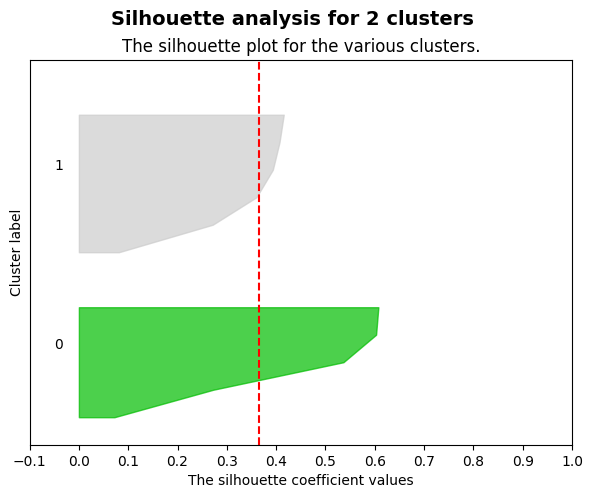


 For n_clusters = 3 The average silhouette_score is : 0.3463153324563482


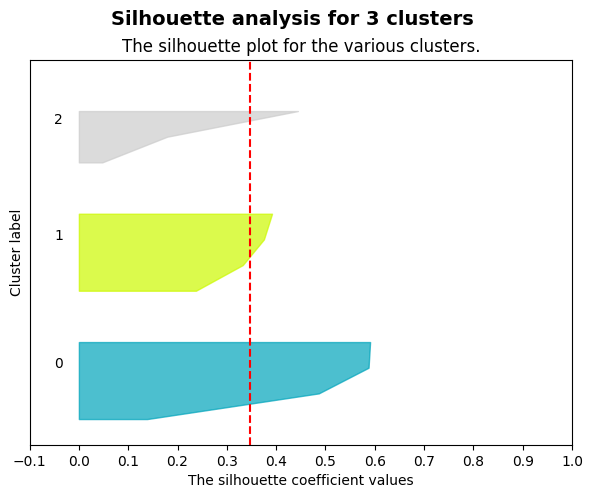


 For n_clusters = 4 The average silhouette_score is : 0.3048257834103282


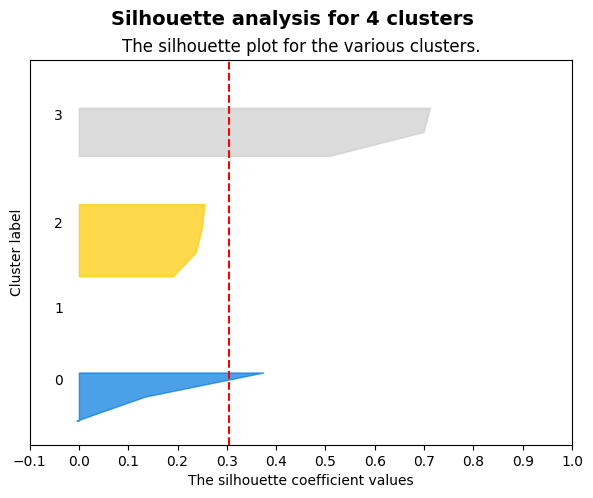


 For n_clusters = 5 The average silhouette_score is : 0.31901570676077295


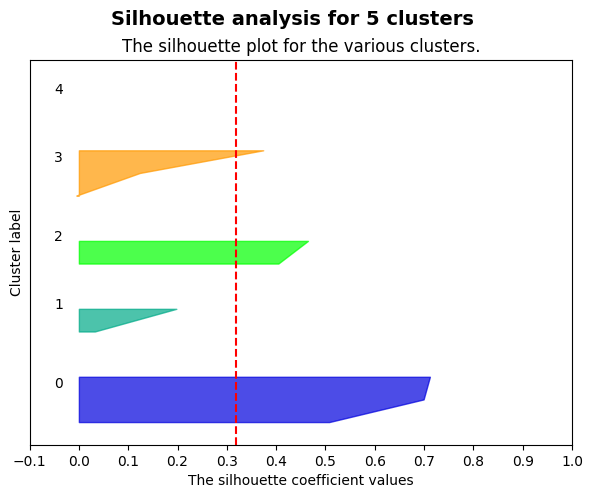


 For n_clusters = 6 The average silhouette_score is : 0.32028830560393723


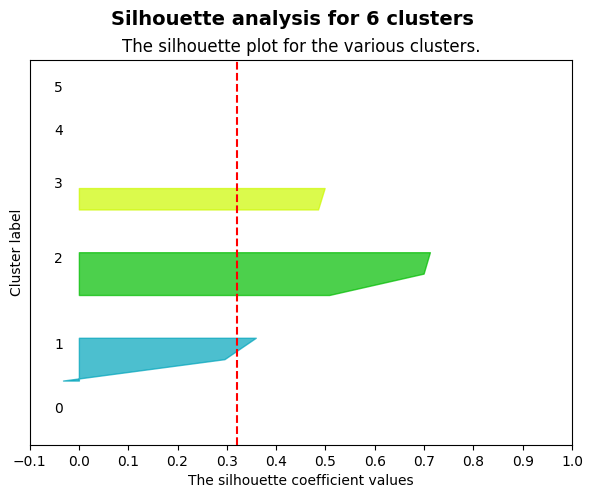


 For n_clusters = 7 The average silhouette_score is : 0.33080381199144054


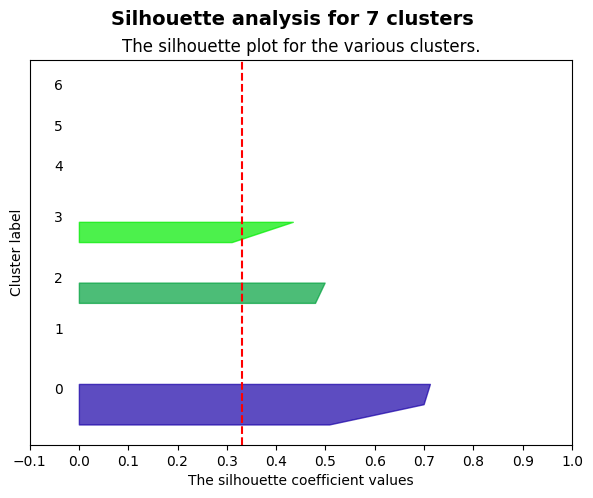

In [ ]:
#Plotting silhouette coefficients for every sample for different numbers of clusters
range_k = [k for k in range (2,8)]

for k in range_k:
  fig, (ax1) = plt.subplots(1)
  fig.set_size_inches(7,5)
  
  # Silhouette coeffitient lies within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The k+1 inserts blank space between silhouette
  # plots of individual clusters, to clearly distinguish them
  ax1.set_ylim([0, len(data_array) + (k + 1)])
  
  kmeans_pp = KMeans(n_clusters=k, **kmeans_kwargs)
  labels = kmeans_pp.fit_predict(data_array)
  
  #Average silhouette score of a cluster
  silhouette_avg = silhouette_score(data_array, labels, metric='euclidean')
  print(
        "\n",
        "For n_clusters =",
       k,
        "The average silhouette_score is :",
        silhouette_avg
        
    )
  # Silhouette value for each sample
  sample_silhouette_values = silhouette_samples(data_array, labels)
  
  y_lower = 1
  for i in range(k):
        # Aggregating the silhouette scores for samples belonging to
        # cluster i, and sorting them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i+1) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 1  # 1 for the 0 samples
        
  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

    # Show the average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

  
  plt.suptitle(
        "Silhouette analysis for %d clusters"
        % k,
        fontsize=14,
        fontweight="bold",
  )
  plt.show();
  


Sihloette analysis allows to conclude that 4 clusters is also a good choice to make. Although average silhouette value is lower, choise of 4 clusters leads to clusters with smaller difference in size (can be seen from thikness of plots), and also more samples have silhouette score closer to average than when k = 3 is chosen. With k > 4, clusters with silhoutte score of 0 begin to appear, which means that this clusters overlap with others

###Pefrorming cluster analysis and visualising results

For every method, 3 and 4 cluster will be identified. The results will be plotted to show which variables are assigned to a same cluster

#####K-means clustering for k = 3

In [ ]:
data_array

array([[476.61471558, 480.22402954, 481.81488037, ..., 370.65383911,
        367.39877319, 371.66171265],
       [249.30506897, 249.80056763, 250.38711548, ..., 249.92880249,
        250.15072632, 250.37265015],
       [299.83825684, 300.06524658, 300.42855835, ..., 297.72961426,
        297.62844849, 297.5272522 ],
       ...,
       [  3.60117722,   3.6011982 ,   3.60121918, ...,   2.80626988,
          2.80604768,   2.80582523],
       [-40.45188141, -39.2544136 , -37.99485397, ..., -41.5241127 ,
        -42.32547379, -41.6969986 ],
       [-38.07087708, -36.47520065, -34.676548  , ..., -34.7906723 ,
        -36.18478012, -37.01657486]])

In [ ]:
#Random initialization
kmeans = KMeans(n_clusters=3, init = 'random', max_iter=100, n_init = 15, random_state=42)
kmeans.fit(data_array)

KMeans(init='random', max_iter=100, n_clusters=3, n_init=15, random_state=42)

In [ ]:
#To plot, I am using results of clustering predictions and date time values

y=kmeans.predict(data_array)


In [ ]:
y

array([2, 1, 1, 0, 0, 2, 2, 2, 1, 0, 0], dtype=int32)

<ipython-input-81-954185673e24>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(distance_matrix, dtype=np.bool)


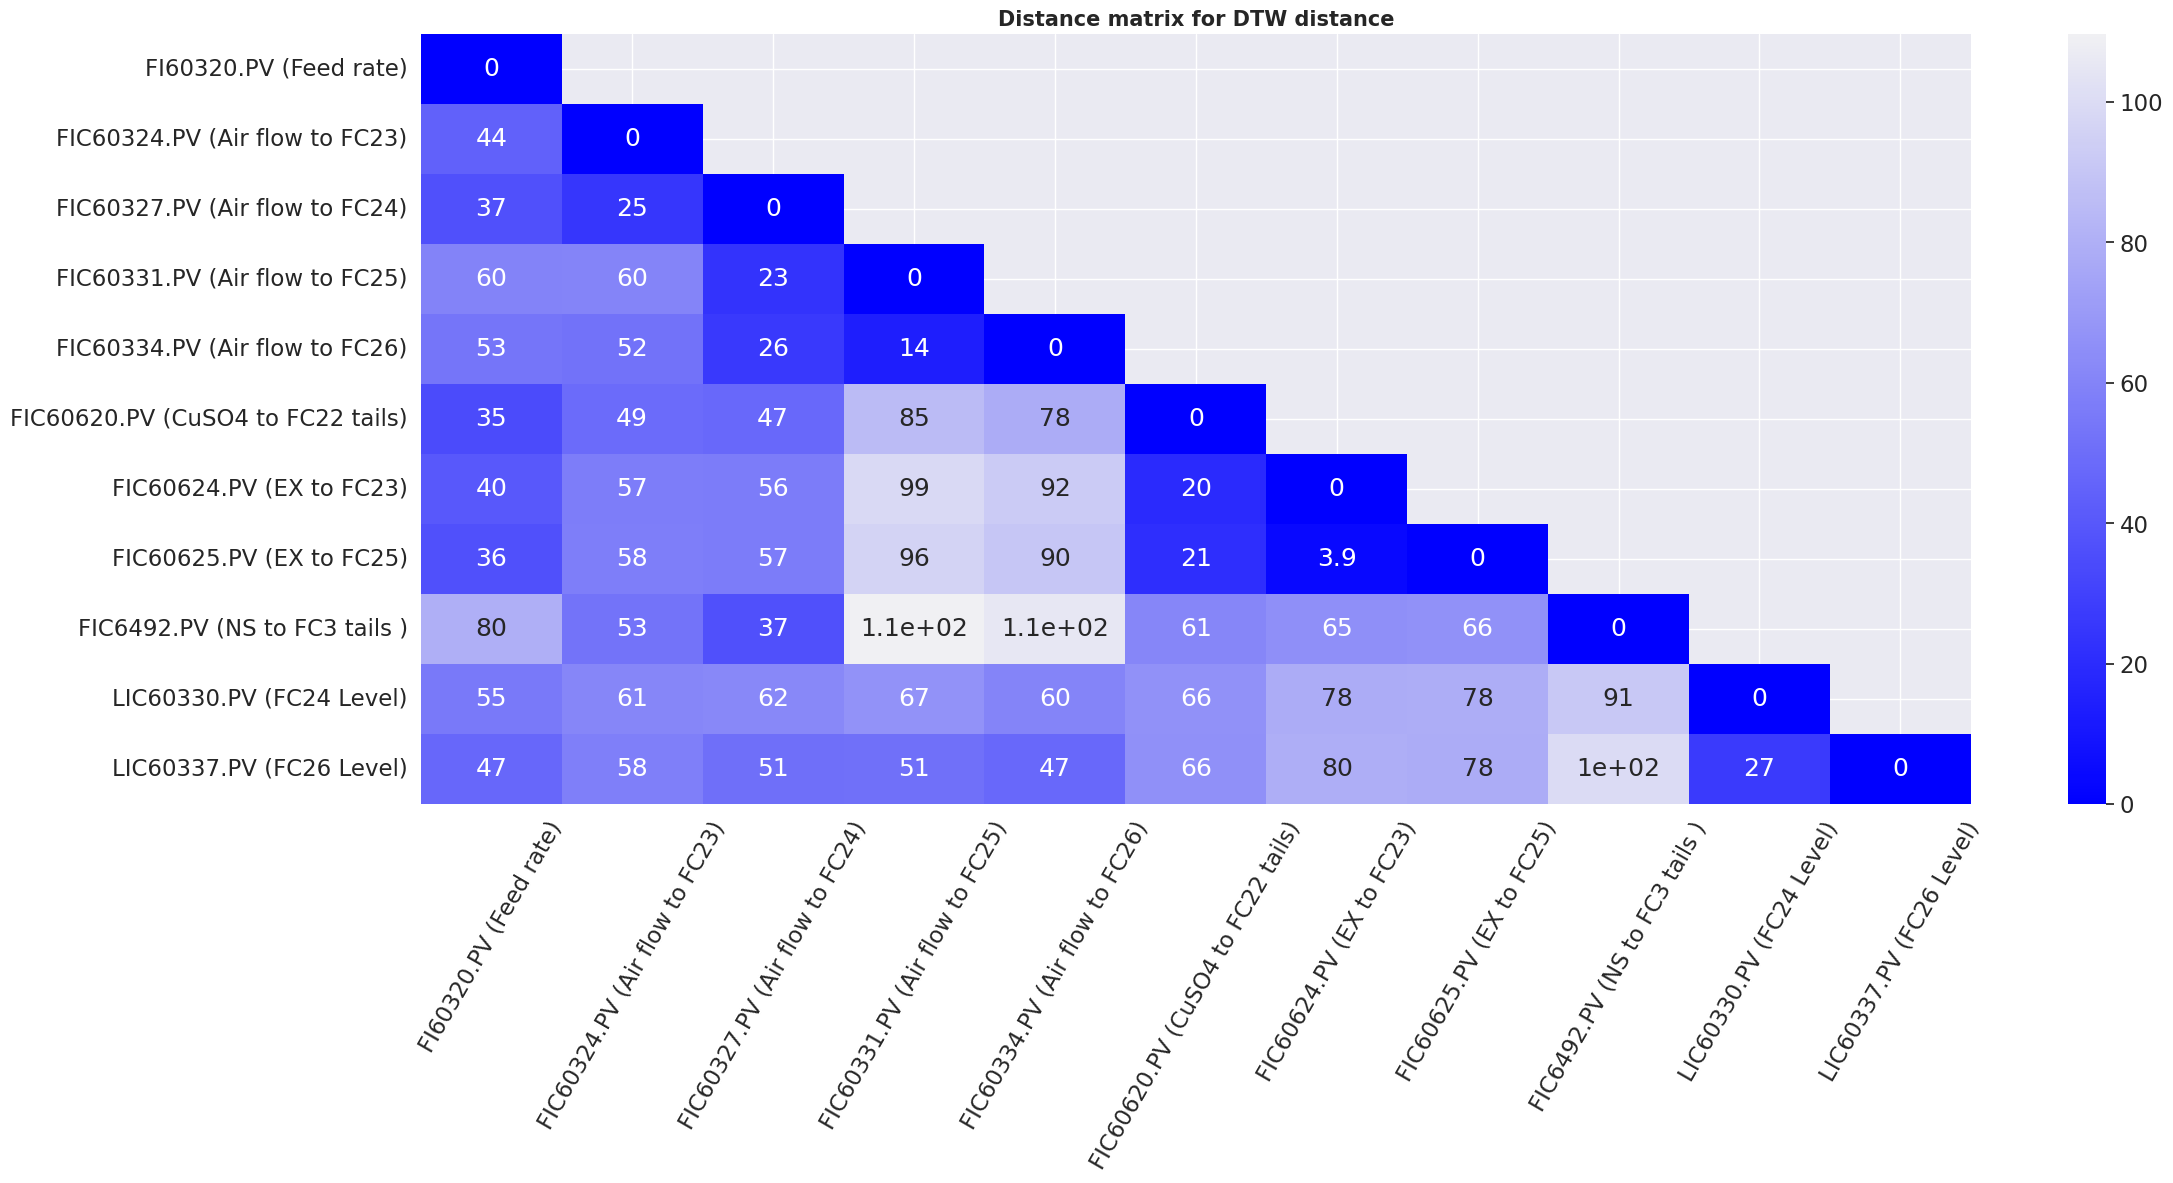

In [ ]:
plt.figure(figsize=(25, 10))
sns.set(font_scale=1.5)
palette = sns.light_palette("blue", n_colors=10000, reverse = True)

# I am masking everything above the main diagonal
mask = np.zeros_like(distance_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Displaying diagonal elements as well
mask[np.diag_indices_from(mask)] = False


ax = sns.heatmap(distance_matrix, annot=True, cmap = palette, mask = mask)
texts = [t.get_text() for t in ax.get_xticklabels()]
texts = [df_descriptions.columns[t] +  ' (' + df_descriptions.loc['Description'][t] + ')' for t in range(len(texts))]
ax.set_yticklabels(texts, rotation = 0);
ax.set_xticklabels(texts,rotation=60);

plt.title("Distance matrix for DTW distance",fontsize=15, fontweight = "bold")
plt.show();

In [ ]:
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage

def hierarchical_clustering(dist_mat, method = 'complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    # if method == 'single':
    #     Z = single(distance_matrix)
    # if method == 'average':
    #     Z = average(distance_matrix)
    
    fig = plt.figure(figsize=(23, 12))
    labels = [df_descriptions.columns[t] +  ' (' + df_descriptions.loc['Description'][t] + ')' for t in range(len(df_descriptions.columns))]
    dn = dendrogram(Z, labels = labels, leaf_font_size = 7)
    plt.axhline(y=20000, c='black', lw=1, linestyle='dashed')
    #plt.axhline(y=15000, c='black', lw=1, linestyle='dashed')
    plt.title(f"Dendrogram for Hierarchical clustering based on DTW distance", fontsize = 12, fontweight="bold")
    plt.show()
    
    return Z

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


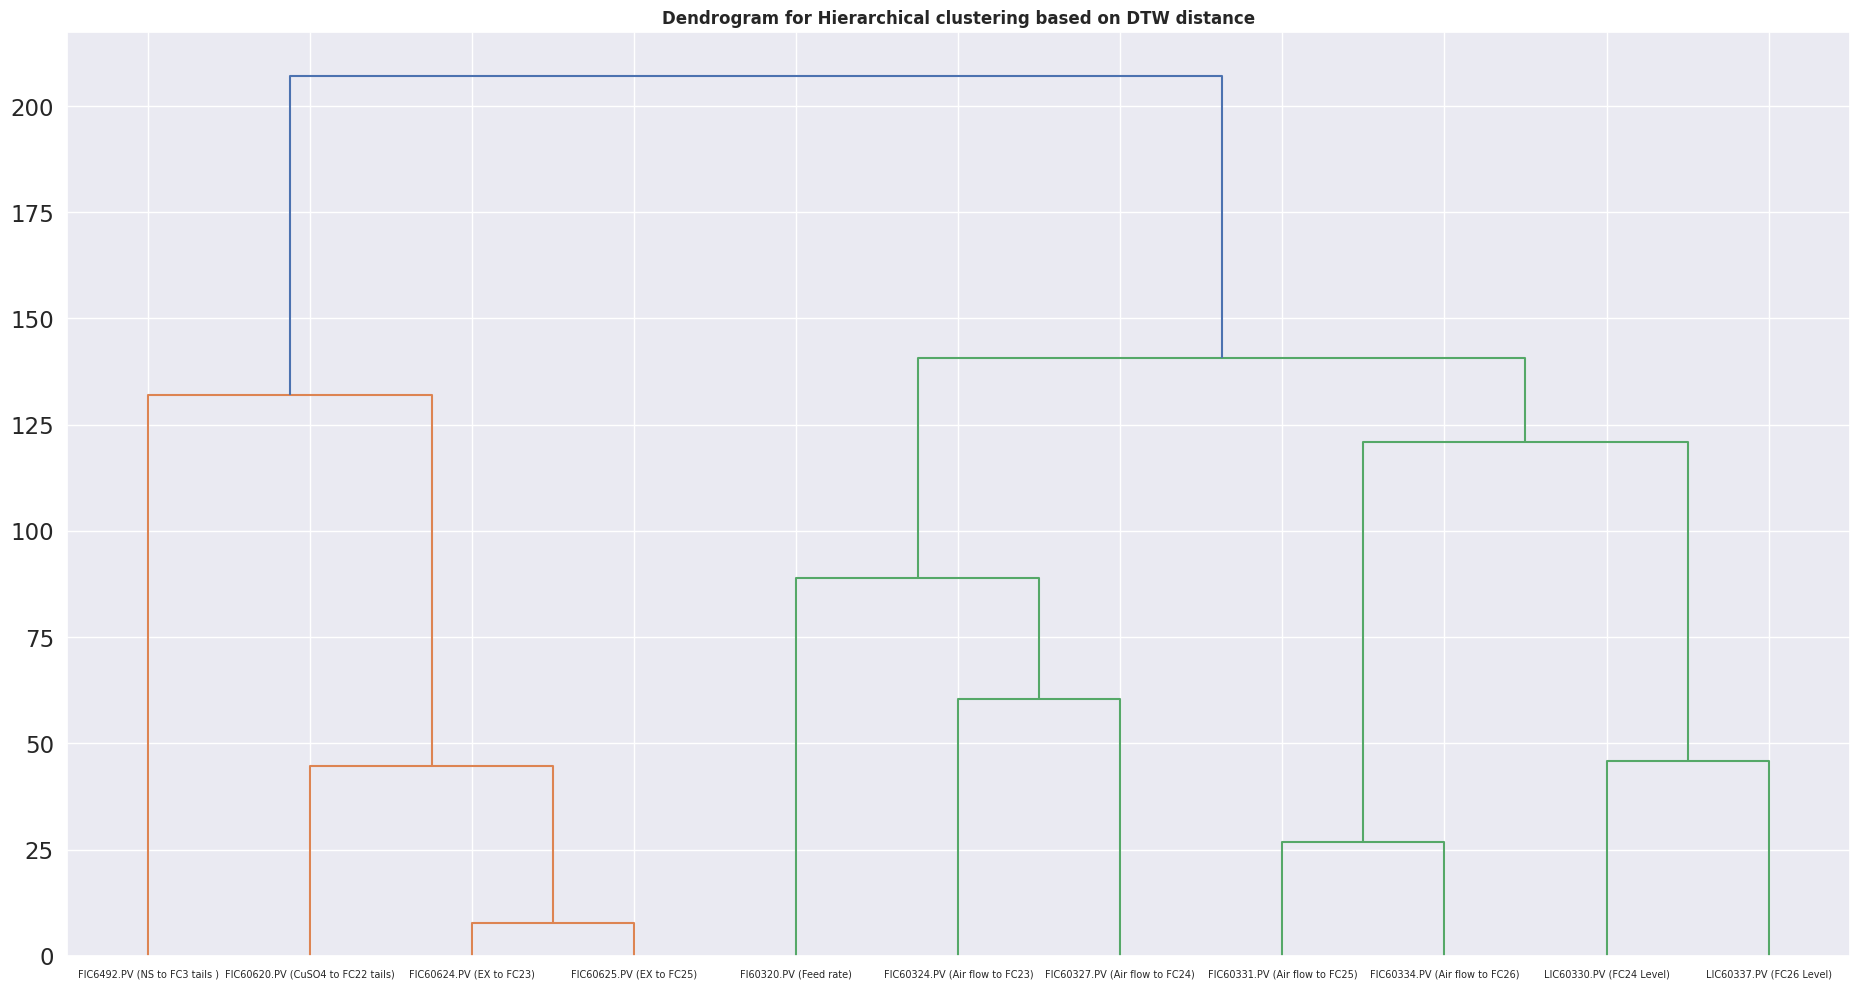

In [ ]:
linkage_matrix = hierarchical_clustering(distance_matrix)

In [ ]:
from scipy.cluster.hierarchy import fcluster

# select maximum number of clusters
cluster_labels_3 = fcluster(linkage_matrix, 3, criterion='maxclust')
print("For 3 clusters labels are: %s"%cluster_labels_3)
#>> 3 unique clusters
cluster_labels_4 = fcluster(linkage_matrix, 4, criterion='maxclust')
print("For 4 clusters labels are: %s"%cluster_labels_4)
#>> 4 unique clusters

# # hand-select an appropriate cut-off on the dendrogram
# cluster_labels = fcluster(linkage_matrix, 60000, criterion='distance')
# print(np.unique(cluster_labels))
# #>> 3 unique clusters
# cluster_labels = fcluster(linkage_matrix, 40000, criterion='distance')
# #print(np.unique(cluster_labels))
# #>> 2 unique clusters

For 3 clusters labels are: [2 2 2 3 3 1 1 1 1 3 3]
For 4 clusters labels are: [3 3 3 4 4 1 1 1 2 4 4]


In [ ]:
silhouette_score(distance_matrix, cluster_labels_3, metric="precomputed")

0.19701181336782347

In [ ]:
kmeans.inertia_

15522.4658118028

In [ ]:
labels = kmeans.labels_
silhouette_score(data_array, labels, metric='euclidean')

0.28755337421613414

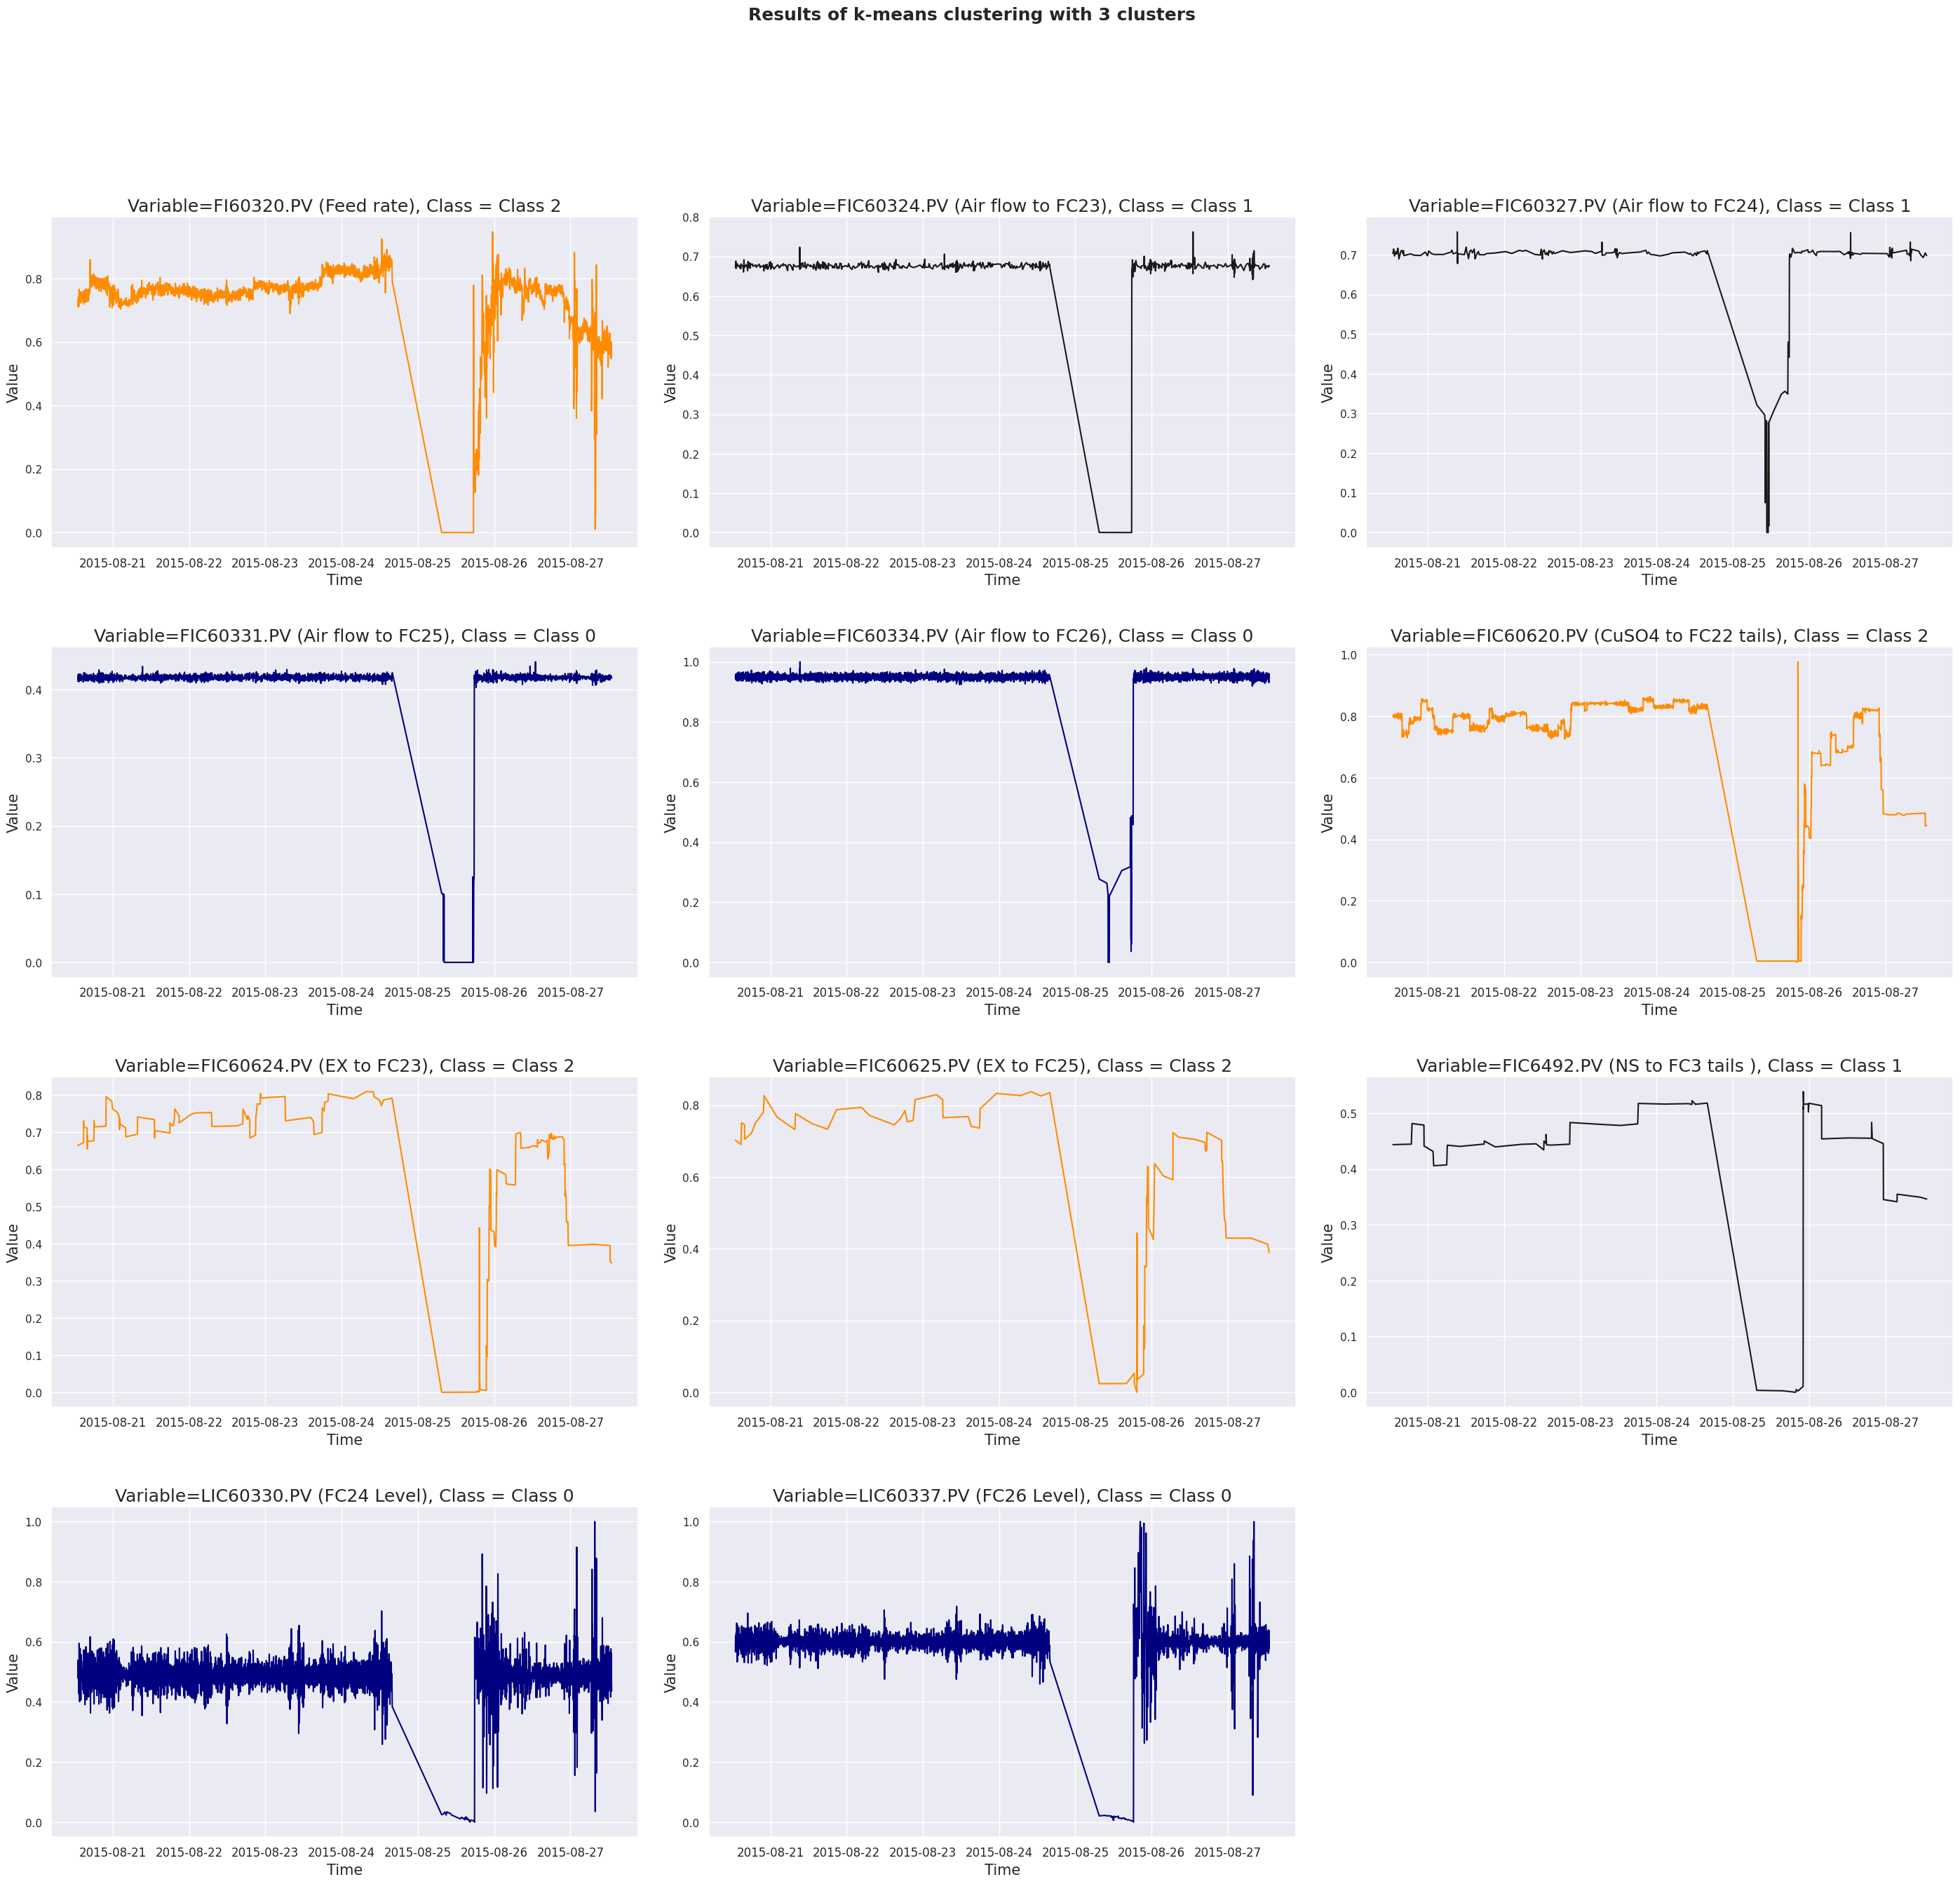

In [ ]:
plt.figure(figsize=(35,30))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange'] + ['k']* 2 + ['navy'] *2 + ['darkorange']*3 + ['k'] +['navy']*2
Names = ['Class 2']+['Class 1']*2+['Class 0']*2+['Class 2']*3 +['Class 1'] + ['Class 0'] *2 
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x, data_array[j-1],color=colors[j-1])
    plt.ylabel('Value',fontsize=15)
    plt.yticks(fontsize = 11)
    plt.xlabel('Time',fontsize=15)
    plt.xticks(fontsize = 12)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=18)
    #plt.ylim(data_array.min(),data_array.max())

plt.suptitle("Results of k-means clustering with 3 clusters", fontsize = 18, fontweight="bold")
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show();

In [ ]:
#checking how result looks
y

array([1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2], dtype=int32)

Checking the inertia criterion, which shows how spread the clusters are (lower is better). Since inertia is counted using the distances between centers of clusters and samples, it will always decrease, so it is meaningful only for comparison of clustering for the same number of clusters, but with different methods

In [ ]:
kmeans.inertia_

98713080.68519928

Main metrics used to evaluate and compare results would be silhouette coefficient, that shows how much does the average distance to objects in a single cluster differ from the average distance to objects in other clusters. Coefficient scales from -1 to 1, with closer to 1 being better, and 0 meaning overlapping clusters

In [ ]:
labels = kmeans.labels_
silhouette_score(data_array, labels, metric='euclidean')

0.799811224422547

Now the same for kmeans++, where centroids are initialized in a more distanced way

In [ ]:
#kmeans++ initialization
kmeans_pp = KMeans(n_clusters=3, init = 'k-means++', max_iter=10, n_init = 5, random_state=42)
kmeans_pp.fit(data_array)
#vars_list = df_input_pvs.T.index.tolist()

KMeans(max_iter=10, n_clusters=3, n_init=5, random_state=42)

In [ ]:
kmeans_pp.labels_

array([0, 2, 2, 1, 1, 0, 0, 0, 2, 1, 1], dtype=int32)

In [ ]:
kmeans_pp.inertia_

15522.4658118028

In [ ]:
silhouette_score(data_array, kmeans_pp.labels_, metric='euclidean')

0.3463153324563482

Even though the labels are assigned differently, the results of two methods are the same essentially, and have similar scores on both used metrics. So for k = 3, only one plot will be built

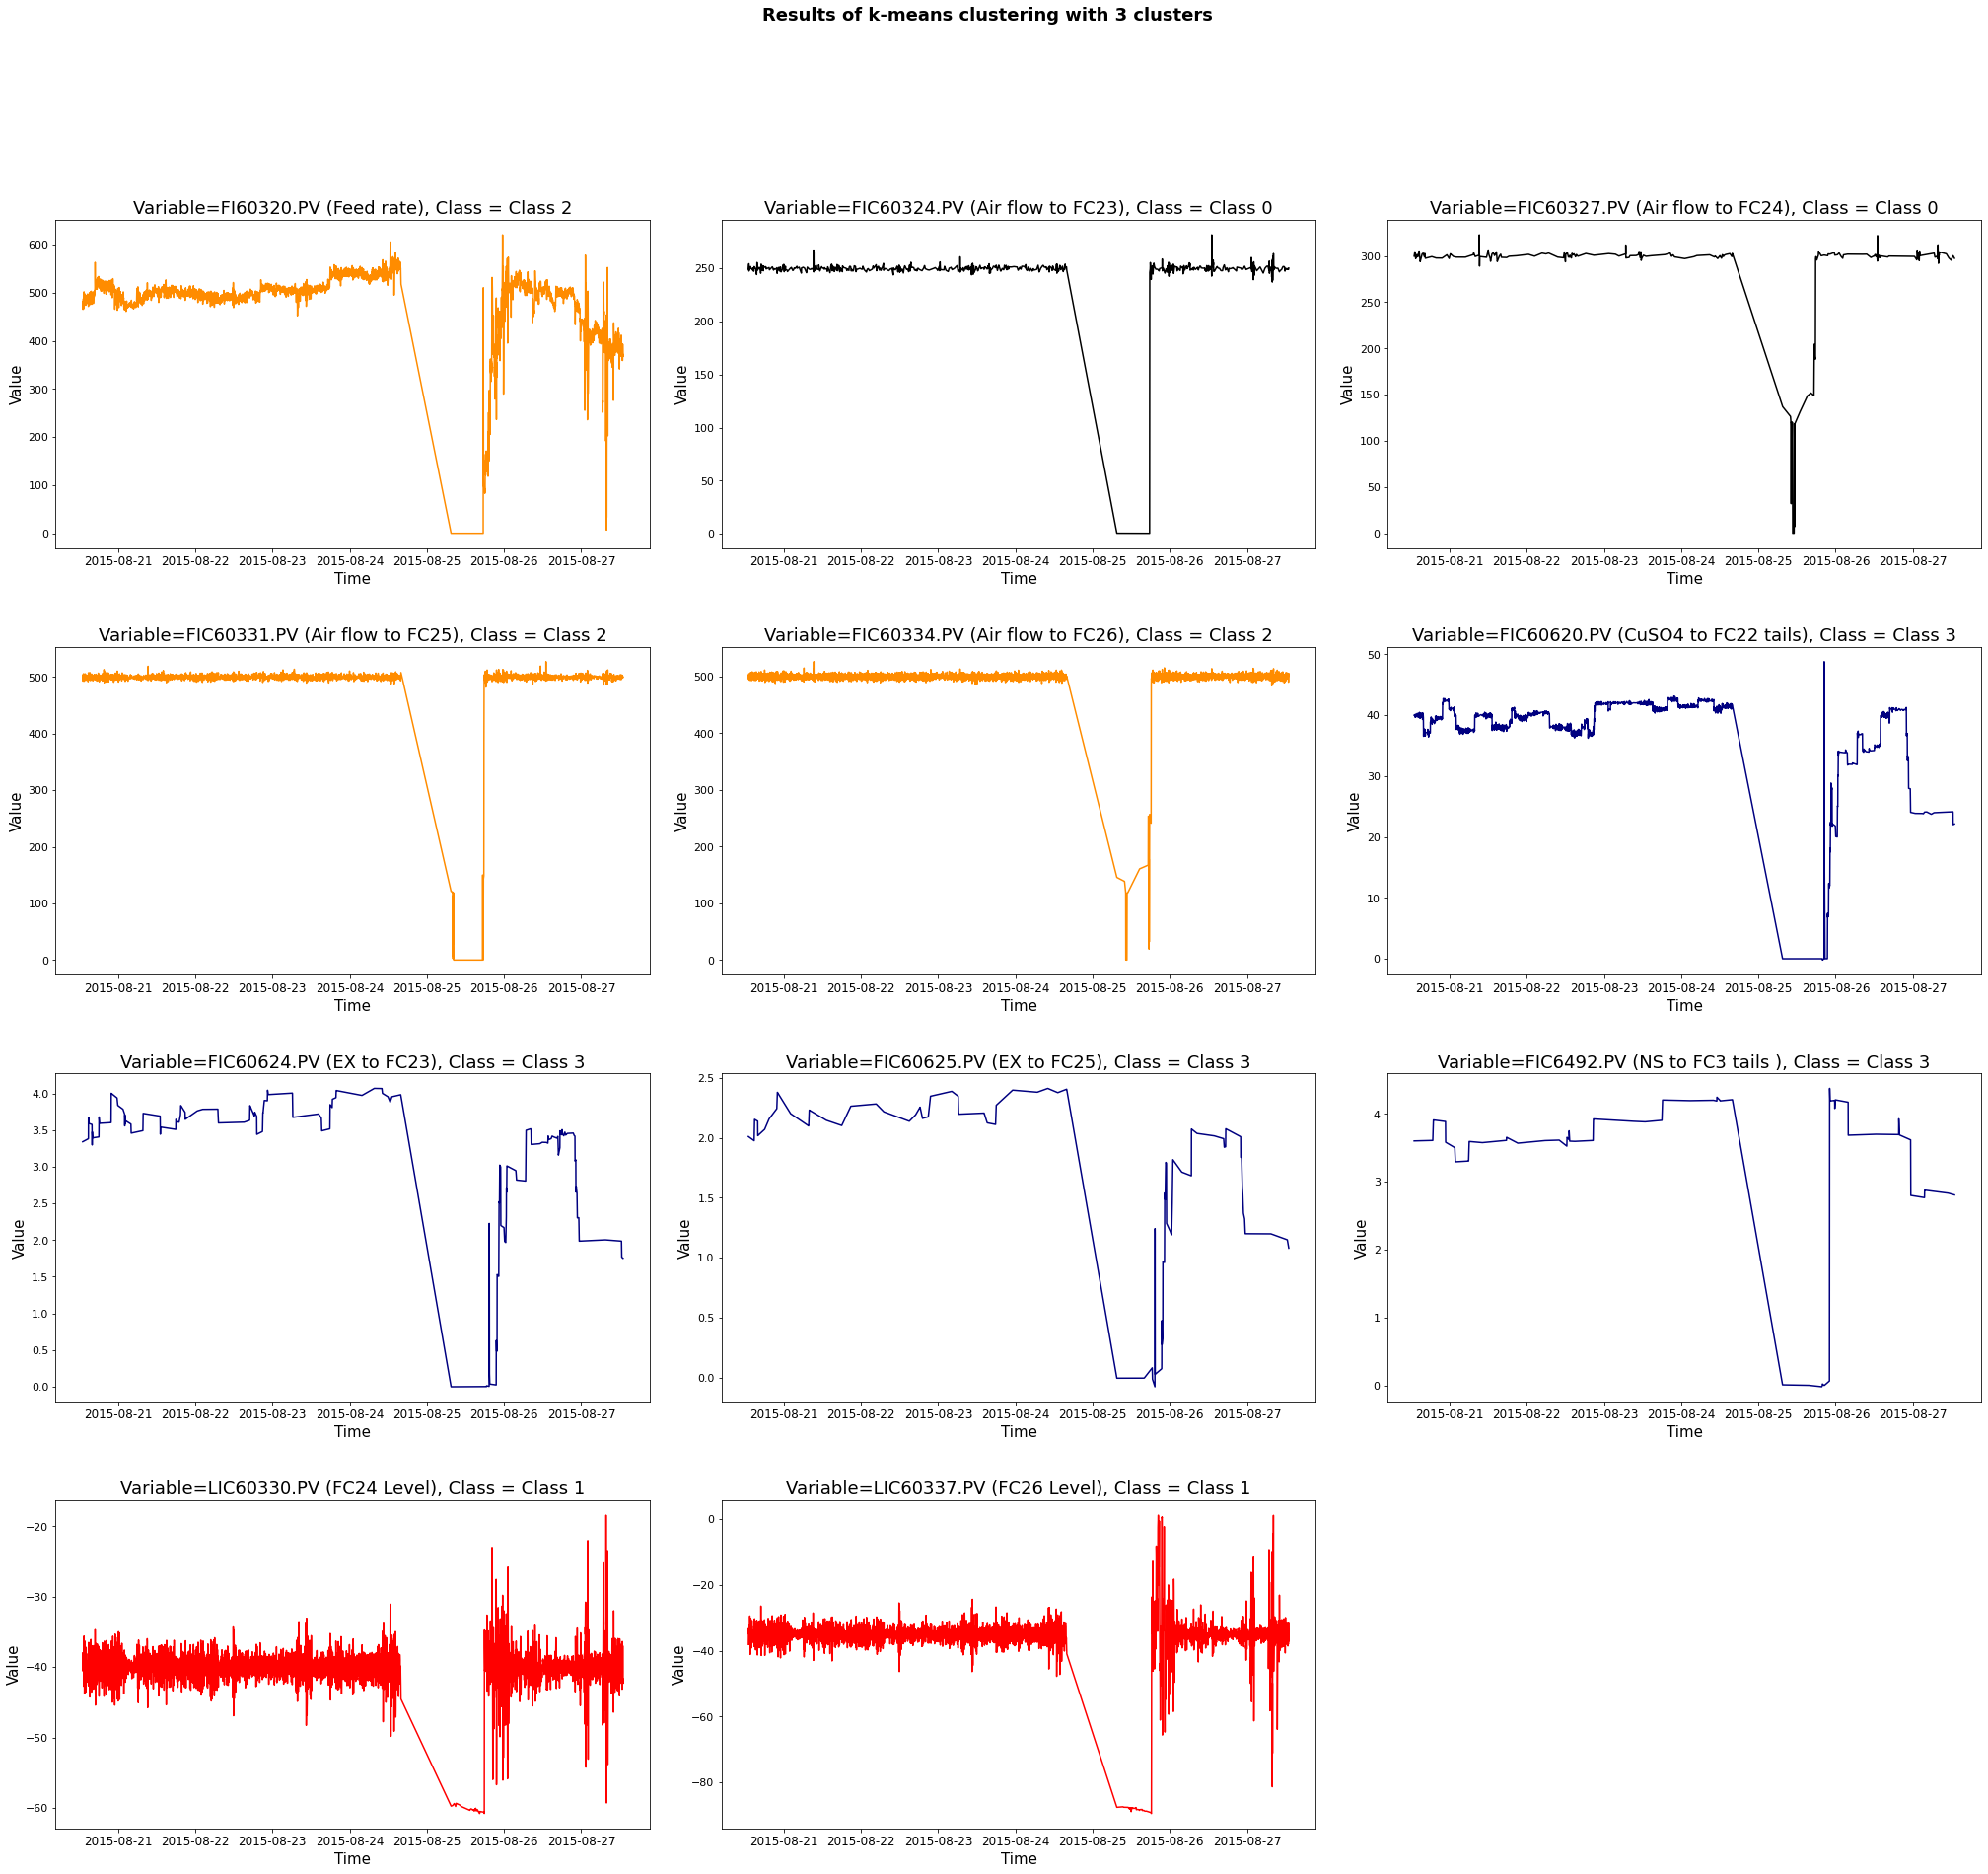

In [ ]:
plt.figure(figsize=(35,30))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange'] + ['k']* 2 + ['darkorange']*2+ ['navy'] *4 +['red']*2
Names = ['Class 2']+['Class 0']*2+['Class 2']*2+['Class 3']*4 +['Class 1'] *2 
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x, data_array[j-1],color=colors[j-1])
    plt.ylabel('Value',fontsize=15)
    plt.yticks(fontsize = 11)
    plt.xlabel('Time',fontsize=15)
    plt.xticks(fontsize = 12)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=18)
    #plt.ylim(data_array.min(),data_array.max())

plt.suptitle("Results of k-means clustering with 3 clusters", fontsize = 18, fontweight="bold")
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show();

#### Now the same pipepline for k = 4

In [ ]:
kmeans = KMeans(n_clusters=4, init = 'random', max_iter=10, n_init = 5, random_state=42)
kmeans.fit(data_array)

KMeans(init='random', max_iter=10, n_clusters=4, n_init=5, random_state=42)

In [ ]:
kmeans.labels_

array([1, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3], dtype=int32)

In [ ]:
kmeans.inertia_

61593404.18235449

In [ ]:
silhouette_score(data_array,kmeans.labels_, metric='euclidean')

0.7285859425460686

In [ ]:
kmeans_pp = KMeans(n_clusters=4, init = 'k-means++', max_iter=10, n_init = 5, random_state=42)
kmeans_pp.fit(data_array)

KMeans(max_iter=10, n_clusters=4, n_init=5, random_state=42)

In [ ]:
kmeans_pp.inertia_

61593404.18235449

In [ ]:
kmeans_pp.labels_

array([2, 0, 0, 2, 2, 3, 3, 3, 3, 1, 1], dtype=int32)

In [ ]:
silhouette_score(data_array,kmeans_pp.labels_, metric='euclidean')

0.7285859425460686

As with 3 clusters, results of k-means and k-means++ are essentially the same

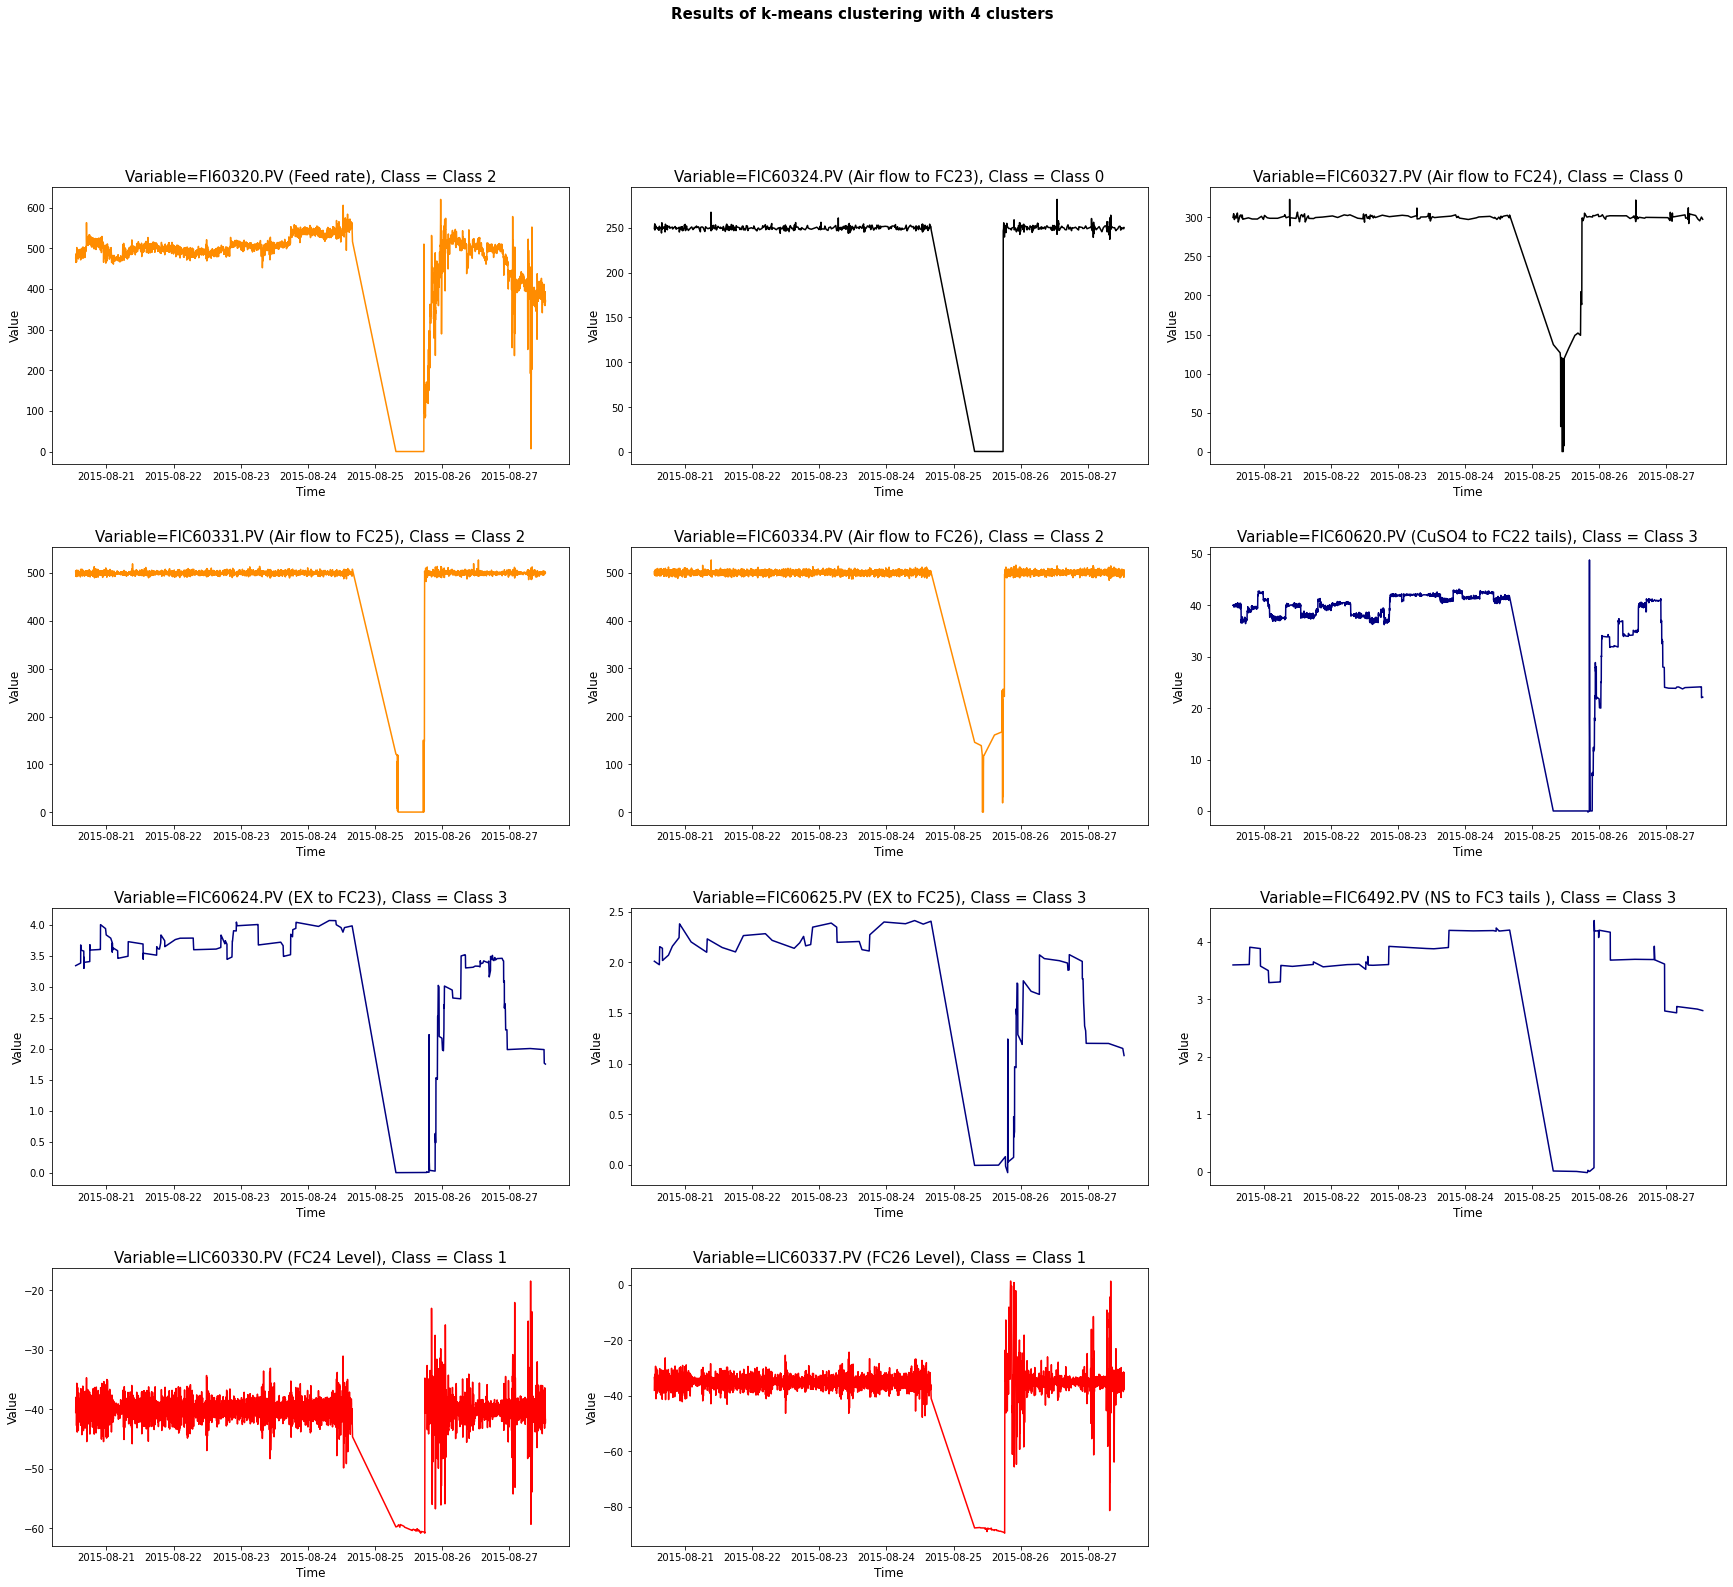

In [ ]:
plt.figure(figsize=(30,25))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange'] + ['k']* 2 + ['darkorange']*2+ ['navy'] *4 +['red']*2
Names = ['Class 2']+['Class 0']*2+['Class 2']*2+['Class 3']*4 +['Class 1'] *2 
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x, data_array[j-1],color=colors[j-1])
    plt.ylabel('Value',fontsize=12)
    plt.xlabel('Time',fontsize=12)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=15)

plt.suptitle("Results of k-means clustering with 4 clusters", fontsize = 15, fontweight="bold")
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show();

### Clustering with DTW metric
The methods above used euclidian distance to measure distances between clusters. DTW metric is concidered theoretically to be better for time-series data. The k-means clustering procedure is now repeated with usage of this metric

First, finding 3 clusters with random initialization method and kmeans++

In [ ]:
#random init
model = TimeSeriesKMeans(n_clusters=3, max_iter=10, n_init = 5, init = 'random', random_state = 42, metric = 'dtw')
model.fit(data_array)

TimeSeriesKMeans(init='random', max_iter=10, metric='dtw', n_init=5,
                 random_state=42)

In [ ]:
model.labels_

array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])

In [ ]:
y = model.predict(data_array)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 11 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [ ]:
y

array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])

In [ ]:
ts_silhouette(data_array, model.labels_, metric="dtw")

0.6635393160809744

In [ ]:
model.inertia_

1893910.270462559

In [ ]:
#kmeans++
model = TimeSeriesKMeans(n_clusters=3, max_iter=10, n_init = 3, init = 'k-means++', random_state = 42, metric = 'dtw')
model.fit(data_array)

In [ ]:
model.labels_

In [ ]:
ts_silhouette(data_array, model.labels_, metric="dtw")

0.8592708628562488

In [ ]:
model.inertia_

The results of random initisallisation in this case are significantly worse than of k-means++. Also the score of k-means++ with DTW seem to be better than in case of usage euclidean distance, but the labels are essentially the same

The results of both random and k-means++ initialisation will be plotted to show the difference in assignments of variables

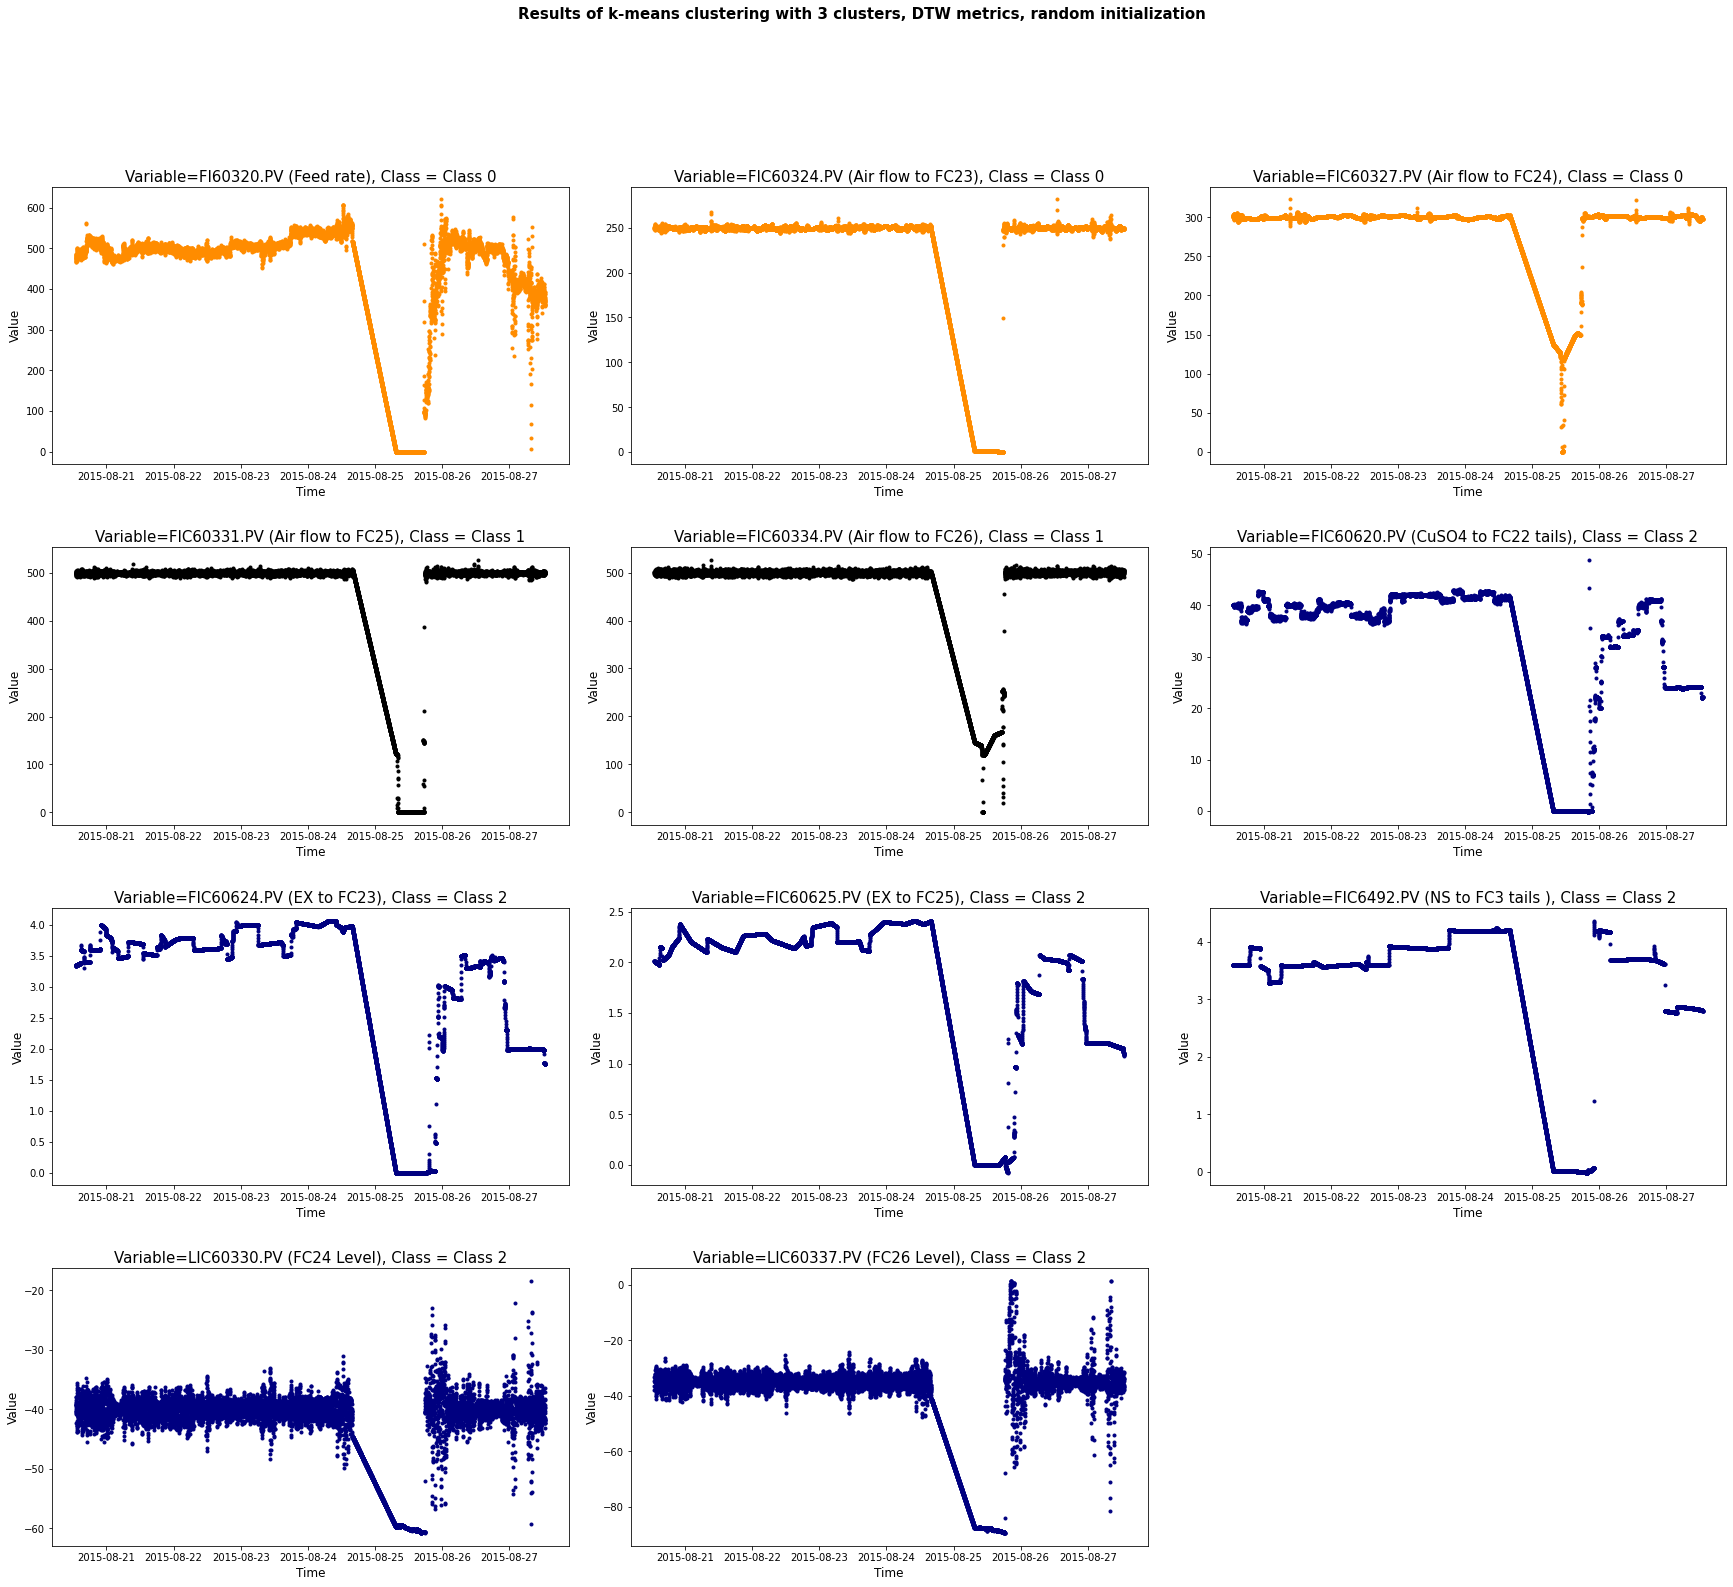

In [ ]:
plt.figure(figsize=(30,25))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange']*3  + ['k']* 2 + ['navy'] *6
Names = ['Class 0']*3+['Class 1']*2+['Class 2']*6
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x, data_array[j-1],'.',color=colors[j-1])
    plt.ylabel('Value',fontsize=12)
    plt.xlabel('Time',fontsize=12)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=15)

plt.suptitle("Results of k-means clustering with 3 clusters, DTW metrics, random initialization", fontsize = 15, fontweight="bold")
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show();

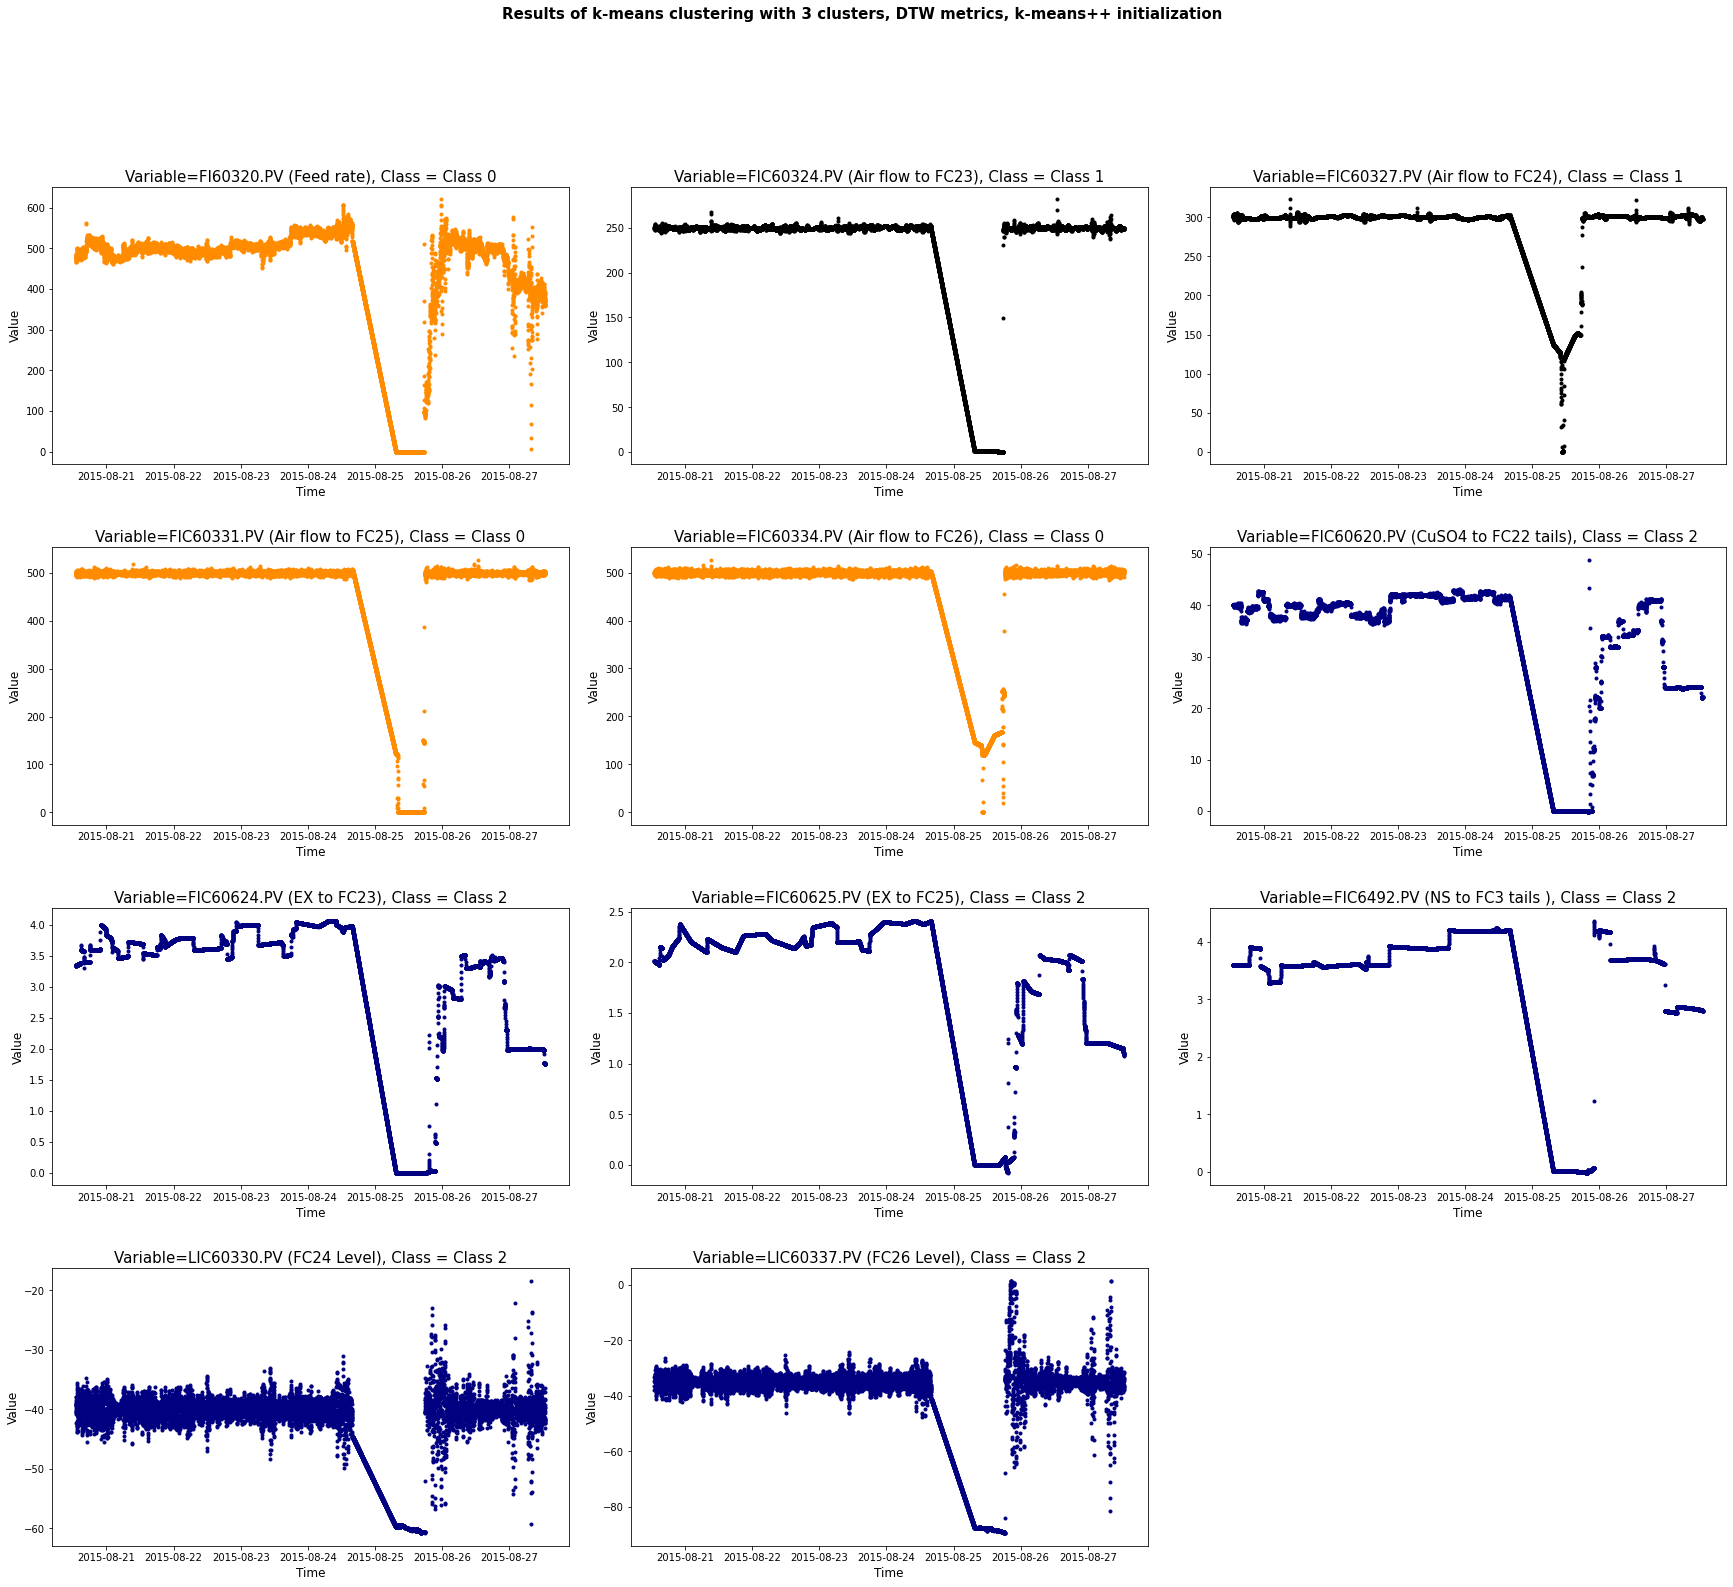

In [ ]:
plt.figure(figsize=(30,25))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange']*1  + ['k']* 2 + ['darkorange']*2+ ['navy'] *6
Names = ['Class 0']*1+['Class 1']*2+['Class 0']*2+['Class 2']*6
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x, data_array[j-1],'.',color=colors[j-1])
    plt.ylabel('Value',fontsize=12)
    plt.xlabel('Time',fontsize=12)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=15)

plt.suptitle("Results of k-means clustering with 3 clusters, DTW metrics, k-means++ initialization", fontsize = 15, fontweight="bold")
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show();

The same pipline for 4 clusters

In [ ]:
model = TimeSeriesKMeans(n_clusters=4, n_init = 5, init = 'random', max_iter=10, random_state = 42, metric = 'dtw')
model.fit(data_array)

TimeSeriesKMeans(init='random', max_iter=10, metric='dtw', n_clusters=4,
                 n_init=5, random_state=42)

In [ ]:
model.labels_

array([0, 3, 3, 0, 0, 1, 1, 1, 1, 2, 2])

In [ ]:
ts_silhouette(data_array, model.labels_, metric="dtw")

0.7953440187872759

In [ ]:
model.inertia_

412156.9896283291

In [ ]:
model = TimeSeriesKMeans(n_clusters=4, n_init = 5, init = 'k-means++', max_iter=10, random_state = 42, metric = 'dtw')
model.fit(data_array)

In [ ]:
model.labels_

NameError: ignored

In [ ]:
ts_silhouette(data_array, model.labels_, metric="dtw")

0.7953440187872759

In [ ]:
model.inertia_

396403.25175257376

Once again, results of k-means and k-means++ are essentially the same, even though k-means++ shows higher score. Moreover, variables are clustered the same way as they were by k-means with euclidean distance

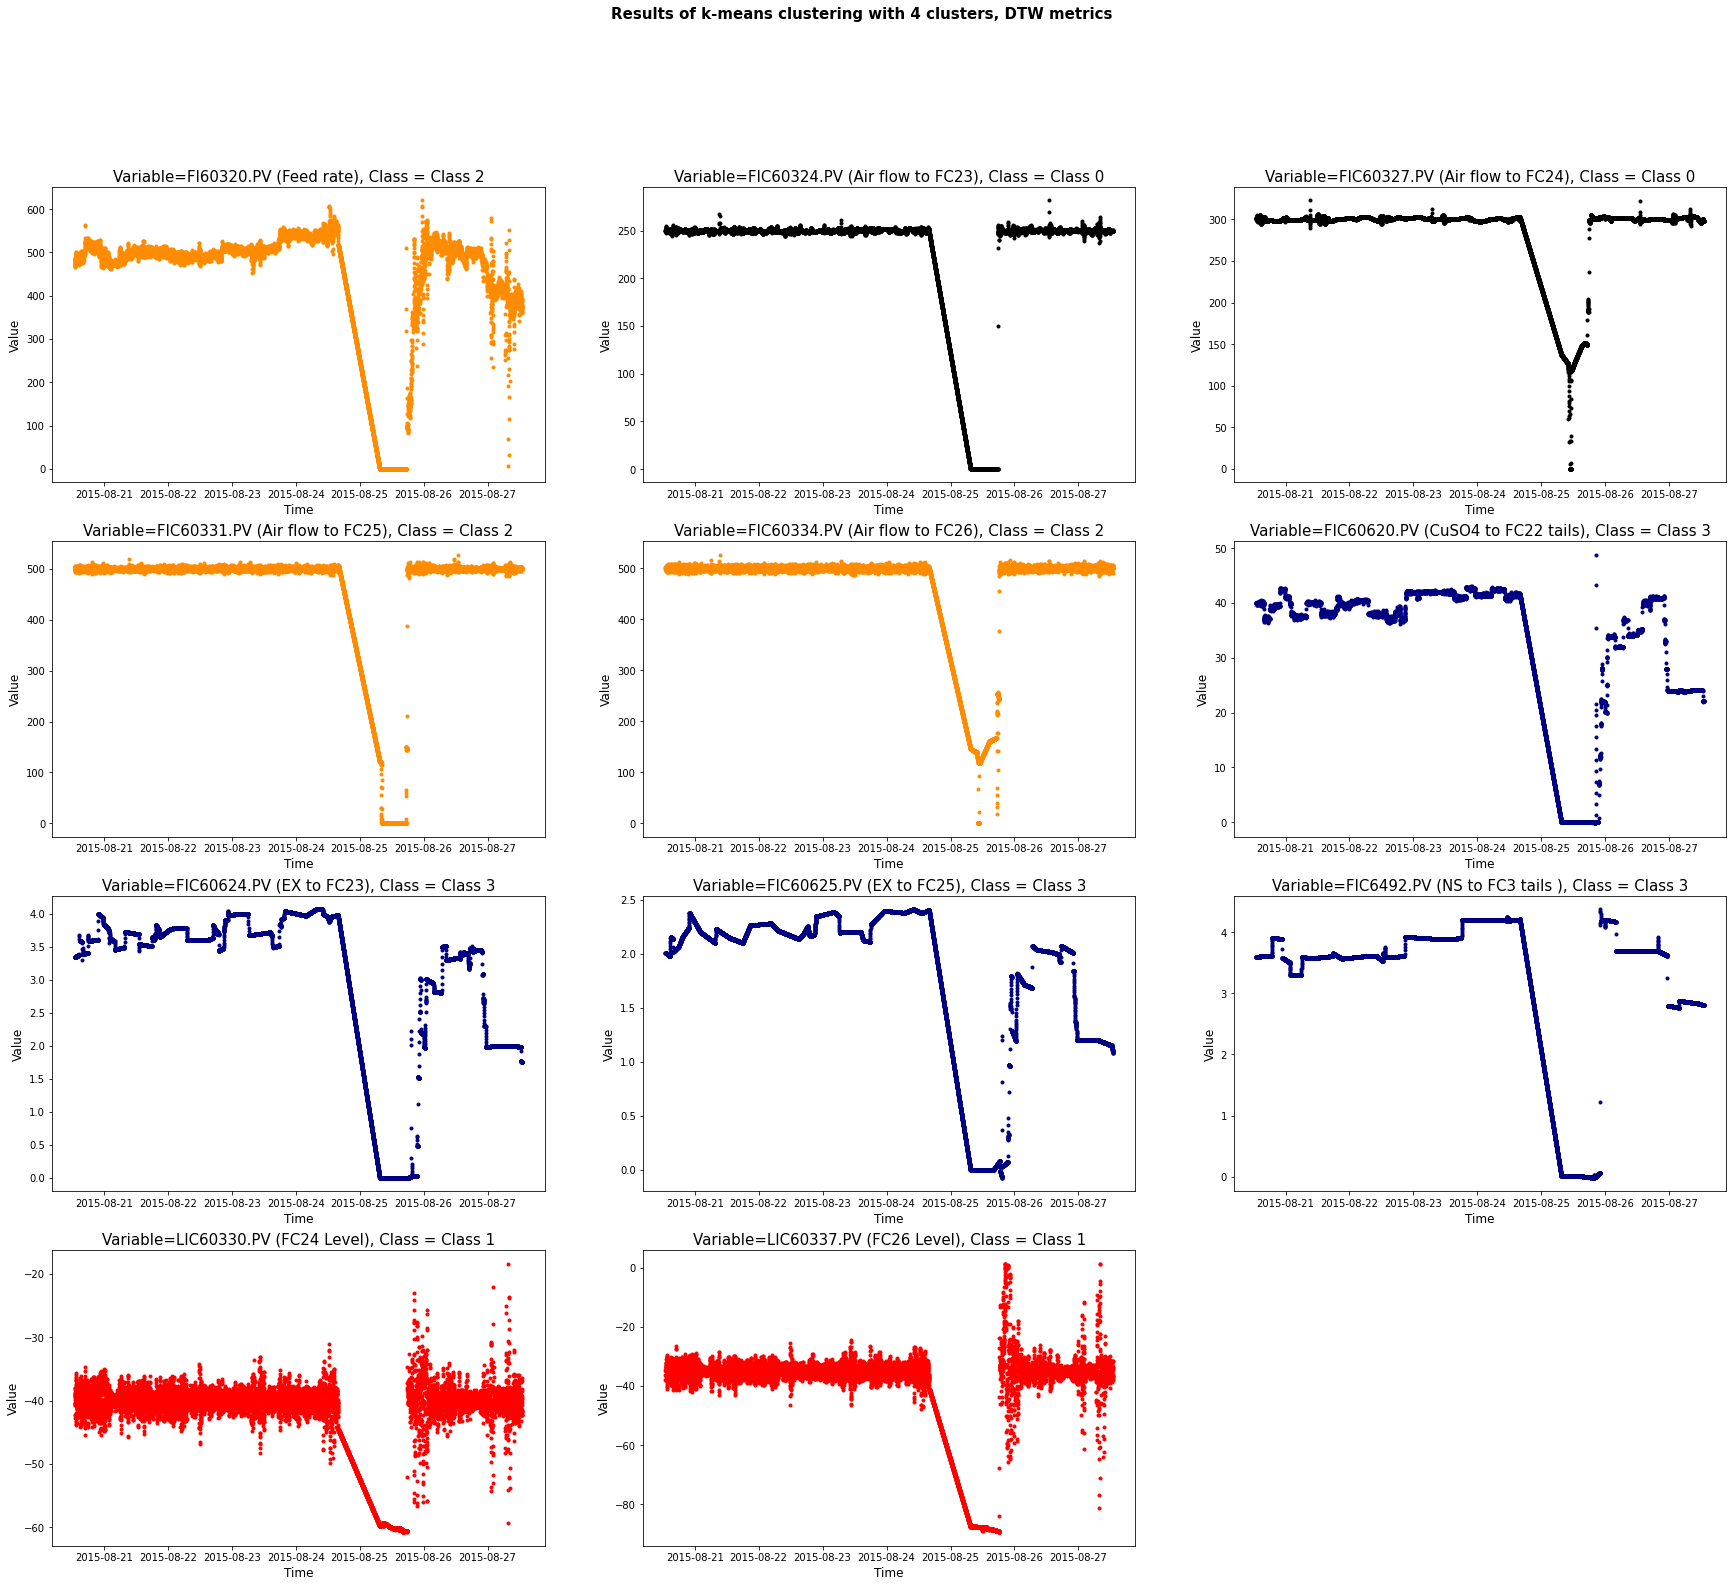

In [ ]:
plt.figure(figsize=(30,25))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange'] + ['k']* 2 + ['darkorange']*2+ ['navy'] *4 +['red']*2
Names = ['Class 2']+['Class 0']*2+['Class 2']*2+['Class 3']*4 +['Class 1'] *2 
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x, data_array[j-1],'.',color=colors[j-1])
    plt.ylabel('Value',fontsize=12)
    plt.xlabel('Time',fontsize=12)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=15)

plt.suptitle("Results of k-means clustering with 3 clusters, DTW metrics, k-means++ initialization", fontsize = 15, fontweight="bold")
plt.suptitle("Results of k-means clustering with 4 clusters, DTW metrics", fontsize = 15, fontweight="bold")
plt.show();

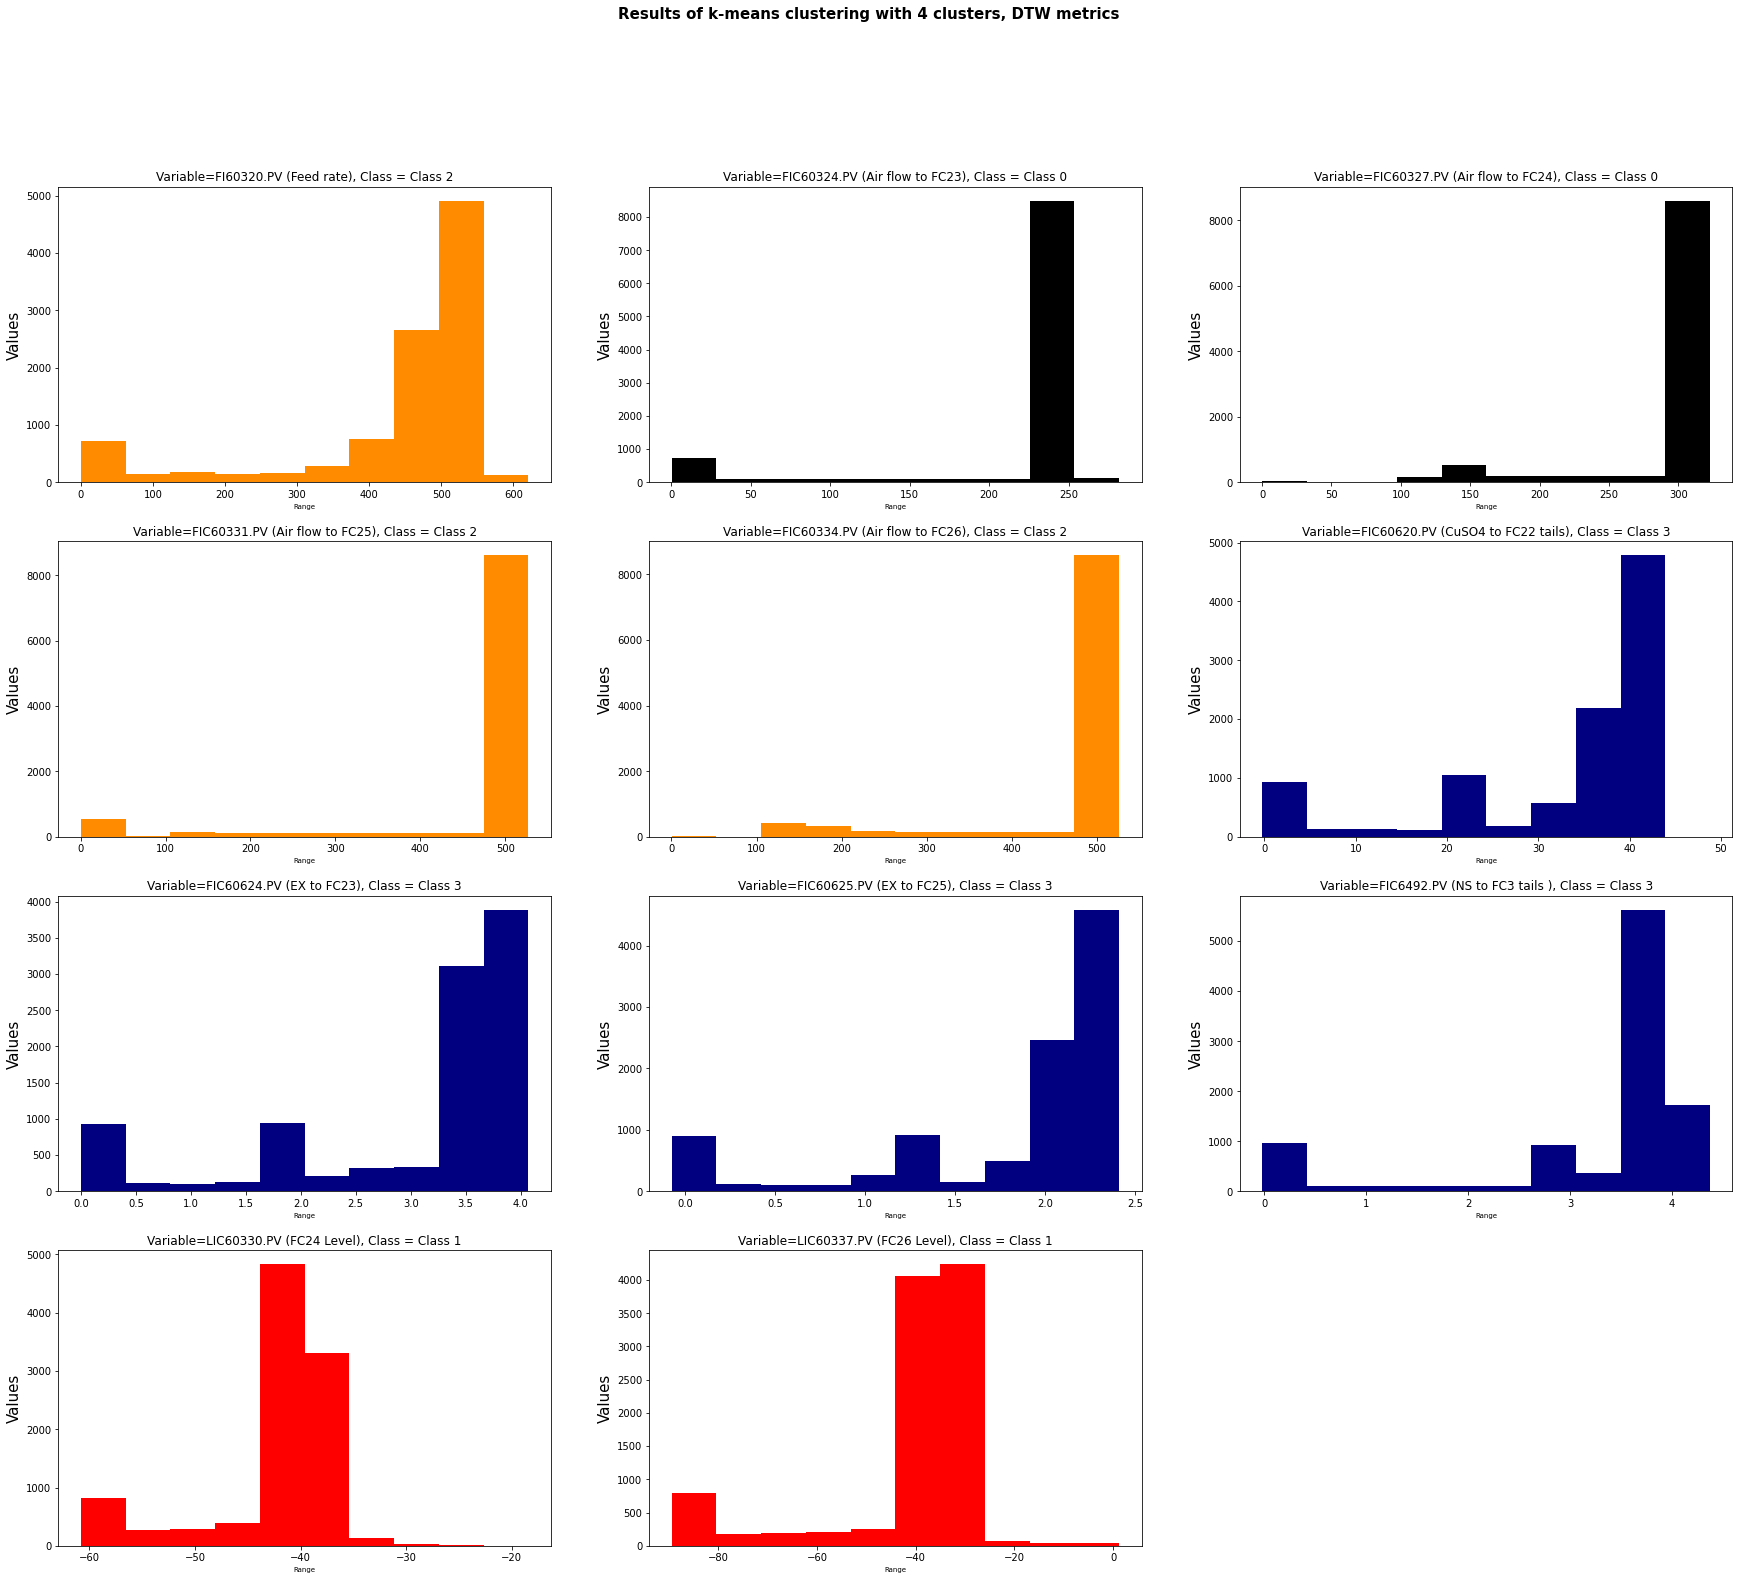

In [ ]:
plt.figure(figsize=(30,25))
#k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2}
colors = ['darkorange'] + ['k']* 2 + ['darkorange']*2+ ['navy'] *4 +['red']*2
Names = ['Class 2']+['Class 0']*2+['Class 2']*2+['Class 3']*4 +['Class 1'] *2 
for j in range(1,12):
    plt.subplot(4,3,j)
    #k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.hist(np.transpose(data_array[j-1]),color=colors[j-1])
    plt.ylabel('Values',fontsize=15)
    plt.xlabel('Range',fontsize=7)
    plt.title('Variable=%s, Class = %s'%(df_input_pvs.columns[j-1] + ' (' + df_descriptions[df_input_pvs.columns[j-1]]['Description'] + ')',Names[j-1]),fontsize=12)

plt.suptitle("Results of k-means clustering with 4 clusters, DTW metrics", fontsize = 15, fontweight="bold")
plt.show();

(array([ 715.,  148.,  175.,  138.,  156.,  282.,  759., 2662., 4911.,
         134.]),
 array([1.87368989e-02, 6.20926384e+01, 1.24166540e+02, 1.86240441e+02,
        2.48314343e+02, 3.10388244e+02, 3.72462146e+02, 4.34536047e+02,
        4.96609949e+02, 5.58683850e+02, 6.20757751e+02]),
 <a list of 10 Patch objects>)

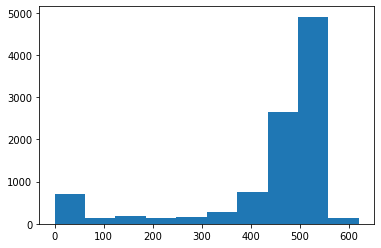

In [ ]:
  plt.hist(np.transpose(data_array[0]))